<a id="top"></a>
# MIRI MRS Spectroscopy of a Late M Star - Detector based extraction

**Use case:** Extract spectra from detector image plane using a PSF model and the pixel variance.<br>
**Data:** Simulated [MIRI MRS](https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-observing-modes/miri-medium-resolution-spectroscopy) spectrum of AGB star.<br>
**Source of Simulations:** [MIRISim](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/mirisim)<br>
**Pipeline Version:** [JWST Pipeline](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline)<br>
**Tools:** jwst, astropy, numpy, scipy.<br>
**Cross-intrument:** No. <br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis) and can be [downloaded](https://github.com/spacetelescope/dat_pyinthesky/tree/main/jdat_notebooks/MRS_Mstar_analysis) directly from the [JDAT Notebook Github directory](https://github.com/spacetelescope/jdat_notebooks).<br>

**Note**: This notebook includes MIRI simulated data cubes obtained using MIRISim (https://wiki.miricle.org//bin/view/Public/MIRISim_Public)
and run through the JWST pipeline (https://jwst-pipeline.readthedocs.io/en/latest/) of
point sources with spectra representative of late M type stars.

## Introduction

This notebook analyzes one star represented by a dusty SED corresponding to the ISO SWS spectrum of
W Per from Kraemer et al. (2002) and Sloan et al. (2003) to cover the MRS spectral range 5-28 microns.  Analysis of JWST spectral cubes requires extracting spatial-spectral features of interest and measuring their attributes.

This is the first notebook, which will process the data and automatically detect and extract spectra for the point source.  The workflow automatically detects sources on the detector image plane to extract the spectrum of the point source. Then it will read in the spectra generated at Stage 3 of the JWST pipeline.


## Import Packages

In [1]:
# Import useful python packages
import numpy as np
from scipy.interpolate import interp1d

# Import packages to display images in the notebook
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt    
%matplotlib notebook   

# Set general plotting options
params = {'legend.fontsize': '18', 'axes.labelsize': '18', 
         'axes.titlesize': '18', 'xtick.labelsize': '18', 
         'ytick.labelsize': '18', 'lines.linewidth': 2, 'axes.linewidth': 2, 'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
# Import astropy packages 
from astropy import units as u
from astropy.io import ascii
from astropy.wcs import WCS
from astropy.table import Table, vstack
from astropy.stats import sigma_clipped_stats
from astropy.nddata import StdDevUncertainty
from astropy.io import fits # added by BAS on 8 April 2021
from astropy.utils.data import get_pkg_data_filename

# To find stars in the MRS spectralcubes and do aperture photometry
from photutils import DAOStarFinder, CircularAperture

# To deal with 1D spectrum
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum
from specutils.manipulation import box_smooth, extract_region, SplineInterpolatedResampler
from specutils.analysis import line_flux, centroid, equivalent_width
from specutils.spectra import SpectralRegion
from specutils import SpectrumList

# To make nice plots with WCS axis
# import aplpy

# To fit a curve to the data
from scipy.optimize import curve_fit

## Set paths to the Data and Outputs

Use MIRISim JWST pipeline processed data in future iterations.

In [4]:
# import pipeline

from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline
from jwst.extract_1d import Extract1dStep
import json
import glob
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
import crds
from jdaviz.app import Application
import asdf
from photutils import aperture_photometry
import os

In [5]:
# Download data if you don't already have it.

import urllib.request

if os.path.exists("20210413_120546_mirisim.tar.gz"):
    print("20210413_120546_mirisim.tar.gz Exists")
else:
    url = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/20210413_120546_mirisim.tar.gz'
    urllib.request.urlretrieve(url, './20210413_120546_mirisim.tar.gz')
    
if os.path.exists("20210413_123047_mirisim.tar.gz"):
    print("20210413_123047_mirisim.tar.gz Exists")
else:
    url = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/20210413_123047_mirisim.tar.gz'
    urllib.request.urlretrieve(url, './20210413_123047_mirisim.tar.gz')
    
if os.path.exists("20210413_125354_mirisim.tar.gz"):
    print("20210413_125354_mirisim.tar.gz Exists")
else:
    url = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/20210413_125354_mirisim.tar.gz'
    urllib.request.urlretrieve(url, './20210413_125354_mirisim.tar.gz')

20210413_120546_mirisim.tar.gz Exists
20210413_123047_mirisim.tar.gz Exists
20210413_125354_mirisim.tar.gz Exists


In [6]:
# Unzip Tar Files

import tarfile

# Unzip files if they haven't already been unzipped
if os.path.exists("20210413_120546_mirisim/"):
    print("20210413_120546_mirisim Exists")
else:
    tar = tarfile.open('./20210413_120546_mirisim.tar.gz', "r:gz")
    tar.extractall()
    tar.close()
    
if os.path.exists("20210413_123047_mirisim/"):
    print("20210413_123047_mirisim Exists")
else:
    tar = tarfile.open('./20210413_123047_mirisim.tar.gz', "r:gz")
    tar.extractall()
    tar.close()
    
if os.path.exists("20210413_125354_mirisim/"):
    print("20210413_125354_mirisim Exists")
else:
    tar = tarfile.open('./20210413_125354_mirisim.tar.gz', "r:gz")
    tar.extractall()
    tar.close()

20210413_120546_mirisim Exists
20210413_123047_mirisim Exists
20210413_125354_mirisim Exists


## Run Pipeline

The various [stages of the pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/main.html#pipelines) can be [run within Python](https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html#running-from-within-python).  For a more in depth tutorial on running the pipelines, check out the [JWebbinars](https://www.stsci.edu/jwst/science-execution/jwebbinars).

In [139]:
# Execute calwebb_detector1 pipeline on raw simulation output.  This will overwrite previous reductions.

allshortfiles = glob.glob('20210413_*_mirisim/det_images/*MIRIFUSHORT*fits')
alllongfiles = glob.glob('20210413_*_mirisim/det_images/*MIRIFULONG*fits')
      
pipe1short = Detector1Pipeline()

# run calwebb_detector1 on the MIRIFUSHORT data separate from MIRIFULONG data, as it saves time this way
for shortfile in allshortfiles:
    print(shortfile)
    baseshort, remaindershort = shortfile.split('.')
    
    # If you run your own simulations, you will need to update these hardcoded files.
    beforestuffshort, dateafterstuffshort = shortfile.split('20210413_')    
    datestringshort, afterstuffshort = dateafterstuffshort.split('_mirisim')
    
    pipe1short.refpix.skip = True
    pipe1short.output_file = baseshort + datestringshort
    
    pipe1short.run(shortfile)

pipe1long = Detector1Pipeline()

for longfile in alllongfiles:
    print(longfile)
    baselong, remainderlong = longfile.split('.')
    
    # If you run your own simulations, you will need to update these hardcoded files.
    beforestufflong, dateafterstufflong = longfile.split('20210413_')
    datestringlong, afterstufflong = dateafterstufflong.split('_mirisim')
    
    pipe1long.refpix.skip = True
    pipe1long.output_file = baselong + datestringlong
    
    pipe1long.run(longfile)

2021-12-14 21:22:46,006 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-12-14 21:22:46,010 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-12-14 21:22:46,012 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-12-14 21:22:46,014 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-12-14 21:22:46,016 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-12-14 21:22:46,018 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-12-14 21:22:46,020 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-12-14 21:22:46,023 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-12-14 21:22:46,024 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-12-14 21:22:46,028 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-12-14 2

20210413_125354_mirisim/det_images/det_image_seq1_MIRIFULONG_34LONGexp1.fits


2021-12-14 21:22:47,025 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34LONGexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-12-14 21:22:47,032 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits'.
2021-12-14 21:22:47,033 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-12-14 21:22:47,033 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_ipc_0007.fits'.
2021-12-14 21:22:47,034 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0022.fits'.
2021-12-1

2021-12-14 21:22:50,763 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:22:50,790 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0022.fits
2021-12-14 21:22:51,226 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-12-14 21:22:51,392 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).
2021-12-14 21:22:51,393 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, '

2021-12-14 21:23:25,832 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2021-12-14 21:23:25,833 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3
2021-12-14 21:23:25,996 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-12-14 21:23:26,152 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).
2021-12-14 21:23:26,155 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:23:26,207 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-12-14 21:23:2

20210413_125354_mirisim/det_images/det_image_seq2_MIRIFULONG_34LONGexp1.fits


2021-12-14 21:23:27,235 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34LONGexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-12-14 21:23:27,239 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits'.
2021-12-14 21:23:27,240 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-12-14 21:23:27,241 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_ipc_0007.fits'.
2021-12-14 21:23:27,242 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0022.fits'.
2021-12-1

2021-12-14 21:23:30,564 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:23:30,594 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0022.fits
2021-12-14 21:23:30,961 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-12-14 21:23:31,121 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).
2021-12-14 21:23:31,122 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 

2021-12-14 21:24:06,062 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2021-12-14 21:24:06,063 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3
2021-12-14 21:24:06,228 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-12-14 21:24:06,389 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).
2021-12-14 21:24:06,391 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:24:06,445 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-12-14 21:24:0

20210413_125354_mirisim/det_images/det_image_seq3_MIRIFULONG_34LONGexp1.fits


2021-12-14 21:24:07,458 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34LONGexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-12-14 21:24:07,462 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits'.
2021-12-14 21:24:07,463 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-12-14 21:24:07,464 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_ipc_0007.fits'.
2021-12-14 21:24:07,464 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0022.fits'.
2021-12-1

2021-12-14 21:24:10,748 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:24:10,778 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0022.fits
2021-12-14 21:24:11,141 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-12-14 21:24:11,304 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).
2021-12-14 21:24:11,306 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 

2021-12-14 21:24:43,266 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2021-12-14 21:24:43,267 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3
2021-12-14 21:24:43,434 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-12-14 21:24:43,597 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).
2021-12-14 21:24:43,598 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:24:43,650 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-12-14 21:24:4

20210413_125354_mirisim/det_images/det_image_seq4_MIRIFULONG_34LONGexp1.fits


2021-12-14 21:24:44,663 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34LONGexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-12-14 21:24:44,668 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits'.
2021-12-14 21:24:44,668 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-12-14 21:24:44,669 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_ipc_0007.fits'.
2021-12-14 21:24:44,670 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0022.fits'.
2021-12-1

2021-12-14 21:24:47,946 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:24:47,977 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0022.fits
2021-12-14 21:24:48,340 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-12-14 21:24:48,496 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).
2021-12-14 21:24:48,498 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 

2021-12-14 21:25:22,099 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2021-12-14 21:25:22,099 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3
2021-12-14 21:25:22,273 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-12-14 21:25:22,450 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).
2021-12-14 21:25:22,452 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:25:22,511 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-12-14 21:25:2

20210413_123047_mirisim/det_images/det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits


2021-12-14 21:25:23,711 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-12-14 21:25:23,716 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits'.
2021-12-14 21:25:23,716 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-12-14 21:25:23,717 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_ipc_0007.fits'.
2021-12-14 21:25:23,718 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0027.fits'.
2021-12

2021-12-14 21:25:27,575 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:25:27,608 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0027.fits
2021-12-14 21:25:28,078 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-12-14 21:25:28,248 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).
2021-12-14 21:25:28,250 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir'

2021-12-14 21:25:36,017 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.
2021-12-14 21:26:01,585 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2021-12-14 21:26:01,586 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3
2021-12-14 21:26:01,763 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-12-14 21:26:01,933 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).
2021-12-14 21:26:01,935 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det

20210413_123047_mirisim/det_images/det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits


2021-12-14 21:26:03,058 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-12-14 21:26:03,063 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits'.
2021-12-14 21:26:03,063 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-12-14 21:26:03,064 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_ipc_0007.fits'.
2021-12-14 21:26:03,065 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0027.fits'.
2021-12

2021-12-14 21:26:06,717 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:26:06,748 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0027.fits
2021-12-14 21:26:07,202 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-12-14 21:26:07,367 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).
2021-12-14 21:26:07,369 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir'

2021-12-14 21:26:15,475 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.
2021-12-14 21:26:39,498 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2021-12-14 21:26:39,498 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3
2021-12-14 21:26:39,660 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-12-14 21:26:39,830 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).
2021-12-14 21:26:39,832 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det

20210413_123047_mirisim/det_images/det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits


2021-12-14 21:26:40,919 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-12-14 21:26:40,925 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits'.
2021-12-14 21:26:40,926 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-12-14 21:26:40,927 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_ipc_0007.fits'.
2021-12-14 21:26:40,928 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0027.fits'.
2021-12

2021-12-14 21:26:44,403 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:26:44,435 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0027.fits
2021-12-14 21:26:44,824 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-12-14 21:26:44,991 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).
2021-12-14 21:26:44,993 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir'

2021-12-14 21:26:52,467 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.
2021-12-14 21:27:16,948 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2021-12-14 21:27:16,948 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3
2021-12-14 21:27:17,112 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-12-14 21:27:17,297 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).
2021-12-14 21:27:17,299 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det

20210413_123047_mirisim/det_images/det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits


2021-12-14 21:27:18,379 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-12-14 21:27:18,383 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits'.
2021-12-14 21:27:18,384 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-12-14 21:27:18,385 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_ipc_0007.fits'.
2021-12-14 21:27:18,385 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0027.fits'.
2021-12

2021-12-14 21:27:21,713 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:27:21,743 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0027.fits
2021-12-14 21:27:22,113 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-12-14 21:27:22,277 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).
2021-12-14 21:27:22,279 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir'

2021-12-14 21:27:29,435 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.
2021-12-14 21:27:53,614 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2021-12-14 21:27:53,615 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3
2021-12-14 21:27:53,774 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-12-14 21:27:53,938 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).
2021-12-14 21:27:53,939 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det

20210413_120546_mirisim/det_images/det_image_seq1_MIRIFULONG_34SHORTexp1.fits


2021-12-14 21:27:55,273 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34SHORTexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-12-14 21:27:55,278 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits'.
2021-12-14 21:27:55,279 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-12-14 21:27:55,280 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_ipc_0007.fits'.
2021-12-14 21:27:55,280 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0026.fits'.
2021-12-

2021-12-14 21:27:58,877 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:27:58,908 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0026.fits
2021-12-14 21:27:59,350 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-12-14 21:27:59,513 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).
2021-12-14 21:27:59,515 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir':

2021-12-14 21:28:07,649 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.
2021-12-14 21:28:32,170 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2021-12-14 21:28:32,170 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3
2021-12-14 21:28:32,323 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-12-14 21:28:32,482 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).
2021-12-14 21:28:32,483 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_

20210413_120546_mirisim/det_images/det_image_seq4_MIRIFULONG_34SHORTexp1.fits


2021-12-14 21:28:33,541 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34SHORTexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-12-14 21:28:33,546 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits'.
2021-12-14 21:28:33,547 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-12-14 21:28:33,547 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_ipc_0007.fits'.
2021-12-14 21:28:33,548 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0026.fits'.
2021-12-

2021-12-14 21:28:36,921 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:28:36,953 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0026.fits
2021-12-14 21:28:37,330 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-12-14 21:28:37,487 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).
2021-12-14 21:28:37,489 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir':

2021-12-14 21:28:45,101 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.
2021-12-14 21:29:10,332 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2021-12-14 21:29:10,333 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3
2021-12-14 21:29:10,488 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-12-14 21:29:10,646 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).
2021-12-14 21:29:10,647 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_

20210413_120546_mirisim/det_images/det_image_seq2_MIRIFULONG_34SHORTexp1.fits


2021-12-14 21:29:11,710 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34SHORTexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-12-14 21:29:11,714 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits'.
2021-12-14 21:29:11,714 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-12-14 21:29:11,715 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_ipc_0007.fits'.
2021-12-14 21:29:11,716 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0026.fits'.
2021-12-

2021-12-14 21:29:15,094 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:29:15,124 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0026.fits
2021-12-14 21:29:15,669 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-12-14 21:29:15,885 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).
2021-12-14 21:29:15,887 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir':

2021-12-14 21:29:24,247 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.
2021-12-14 21:29:49,467 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2021-12-14 21:29:49,467 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3
2021-12-14 21:29:49,622 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-12-14 21:29:49,789 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).
2021-12-14 21:29:49,791 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_

20210413_120546_mirisim/det_images/det_image_seq3_MIRIFULONG_34SHORTexp1.fits


2021-12-14 21:29:50,827 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34SHORTexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-12-14 21:29:50,833 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_dark_0057.fits'.
2021-12-14 21:29:50,834 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-12-14 21:29:50,834 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_ipc_0007.fits'.
2021-12-14 21:29:50,835 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0026.fits'.
2021-12-

2021-12-14 21:29:54,051 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_images'}
2021-12-14 21:29:54,081 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_linearity_0026.fits
2021-12-14 21:29:54,440 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-12-14 21:29:54,601 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).
2021-12-14 21:29:54,602 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir':

2021-12-14 21:30:01,945 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.
2021-12-14 21:30:24,596 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8
2021-12-14 21:30:24,597 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3
2021-12-14 21:30:24,747 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2021-12-14 21:30:24,904 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).
2021-12-14 21:30:24,906 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '20210413_125354_mirisim/det_

In [140]:
# Execute calwebb_spec2 pipeline. This will overwrite previous reductions.

# All the local calwebb_detector1 files
allshortfiles2 = glob.glob('det_image_*_MIRIFUSHORT_*_rate.fits')
alllongfiles2 = glob.glob('det_image_*_MIRIFULONG_*_rate.fits')

for short2file in allshortfiles2:
    print(short2file)
    pipe2short = Spec2Pipeline()
    base2short, remainder2short = short2file.split('.')
    
    pipe2short.straylight.skip = True
    
    # If you run your own simulations, you will need to update these hardcoded files.
    if (short2file == 'det_image_seq1_MIRIFUSHORT_12LONGexp1125354_rate.fits'):
        print('this one will have the level 2b cube built')
    else:
        pipe2short.cube_build.skip = True
    pipe2short.extract_1d.skip = True
    pipe2short.output_file = base2short
        
    pipe2short.run(short2file)

for long2file in alllongfiles2:
    print(long2file)
    pipe2long = Spec2Pipeline()
    base2long, remainder2long = long2file.split('.')
    
    pipe2long.straylight.skip = True
    # If you run your own simulations, you will need to update these hardcoded files.
    if (long2file == 'det_image_seq1_MIRIFULONG_34SHORTexp1120546_rate.fits'):
        print('this one will have the level 2b cube built')
    else:
        pipe2long.cube_build.skip = True
    pipe2long.extract_1d.skip = True
    pipe2long.output_file = base2long
    
    pipe2long.run(long2file)

2021-12-14 21:40:54,644 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:40:54,648 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:40:54,654 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:40:54,656 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:40:54,658 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-12-14 21:40:54,660 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-12-14 21:40:54,664 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2021-12-14 21:40:54,666 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.
2021-12-14 21:40:54,667 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.
2021-12-14 21:40:54,669 - stpipe.Spec2Pipeline.master_

det_image_seq1_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits


2021-12-14 21:40:55,051 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits',).
2021-12-14 21:40:55,069 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq1_MIRIFUSHORT_12MEDIUMexp1123047_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 

2021-12-14 21:40:55,126 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:40:55,131 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:40:55,131 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:40:55,131 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:40:55,132 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:40:55,132 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:40:5

2021-12-14 21:41:00,228 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:41:00,354 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits>,).
2021-12-14 21:41:00,355 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:41:00,373 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:41:00,374 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:41:00,375 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:41:00,375 - stpipe.Spec2Pipeline.srctype - INFO - Input sou

2021-12-14 21:41:06,246 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:41:06,250 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:41:06,251 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFUSHORT_12MEDIUMexp1123047
2021-12-14 21:41:06,251 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:41:07,572 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12MEDIUMexp1123047_cal.fits
2021-12-14 21:41:07,573 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:41:07,587 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:41:07,588 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:41:07,590 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:41:07,591 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:41:07,592 - 

det_image_seq3_MIRIFUSHORT_12LONGexp1125354_rate.fits


2021-12-14 21:41:07,803 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq3_MIRIFUSHORT_12LONGexp1125354_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fals

2021-12-14 21:41:07,860 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:41:07,861 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:41:07,861 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:41:07,861 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:41:07,862 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:41:07,862 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2021-12-14 21:41:07,863 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_distortion_0029.asdf'.
2021-12-14 21:41:07,863 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2021-12-14 21:41:07,864 - stpip

2021-12-14 21:41:12,718 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:41:12,719 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:41:12,719 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:41:12,720 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED
2021-12-14 21:41:12,725 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2021-12-14 21:41:12,856 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1125354_rate.fits>,).
2021-12-14 21:41:12,858 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suff

2021-12-14 21:41:18,541 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:41:19,826 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12LONGexp1125354_cal.fits
2021-12-14 21:41:19,827 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:41:19,843 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:41:19,844 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:41:19,846 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:41:19,847 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:41:19,848 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-12-14 21:41:19,850 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-12-14 21:41:19,853 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2021

det_image_seq2_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits


2021-12-14 21:41:20,054 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq2_MIRIFUSHORT_12MEDIUMexp1123047_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fa

2021-12-14 21:41:20,112 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:41:20,113 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:41:20,113 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:41:20,113 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:41:20,114 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:41:20,114 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2021-12-14 21:41:20,115 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_distortion_0030.asdf'.
2021-12-14 21:41:20,116 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2021-12-14 21:41:20,116 - stpip

2021-12-14 21:41:24,858 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:41:24,859 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:41:24,859 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:41:24,860 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED
2021-12-14 21:41:24,866 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2021-12-14 21:41:24,988 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits>,).
2021-12-14 21:41:24,990 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'su

2021-12-14 21:41:30,632 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:41:31,981 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12MEDIUMexp1123047_cal.fits
2021-12-14 21:41:31,981 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:41:31,996 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:41:31,998 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:41:32,000 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:41:32,001 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:41:32,003 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-12-14 21:41:32,005 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-12-14 21:41:32,009 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
20

det_image_seq4_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits


2021-12-14 21:41:32,232 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq4_MIRIFUSHORT_12MEDIUMexp1123047_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fa

2021-12-14 21:41:32,291 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:41:32,291 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:41:32,291 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:41:32,292 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:41:32,292 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:41:32,293 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2021-12-14 21:41:32,293 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_distortion_0030.asdf'.
2021-12-14 21:41:32,294 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2021-12-14 21:41:32,295 - stpip

2021-12-14 21:41:37,266 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:41:37,267 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:41:37,267 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:41:37,268 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED
2021-12-14 21:41:37,273 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2021-12-14 21:41:37,399 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits>,).
2021-12-14 21:41:37,401 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'su

2021-12-14 21:41:43,863 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:41:45,327 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12MEDIUMexp1123047_cal.fits
2021-12-14 21:41:45,327 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:41:45,343 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:41:45,344 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:41:45,346 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:41:45,347 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:41:45,348 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-12-14 21:41:45,350 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-12-14 21:41:45,354 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
20

det_image_seq4_MIRIFUSHORT_12SHORTexp1120546_rate.fits


2021-12-14 21:41:45,608 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq4_MIRIFUSHORT_12SHORTexp1120546_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fal

2021-12-14 21:41:45,678 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:41:45,679 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:41:45,679 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:41:45,680 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:41:45,680 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:41:45,681 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2021-12-14 21:41:45,681 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_distortion_0031.asdf'.
2021-12-14 21:41:45,682 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2021-12-14 21:41:45,682 - stpip

2021-12-14 21:41:51,266 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:41:51,267 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:41:51,267 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:41:51,268 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED
2021-12-14 21:41:51,275 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2021-12-14 21:41:51,421 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1120546_rate.fits>,).
2021-12-14 21:41:51,424 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suf

2021-12-14 21:41:57,866 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:41:59,198 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12SHORTexp1120546_cal.fits
2021-12-14 21:41:59,199 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:41:59,214 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:41:59,215 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:41:59,218 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:41:59,219 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:41:59,221 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-12-14 21:41:59,223 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-12-14 21:41:59,226 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
202

det_image_seq1_MIRIFUSHORT_12SHORTexp1120546_rate.fits


2021-12-14 21:41:59,441 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq1_MIRIFUSHORT_12SHORTexp1120546_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fal

2021-12-14 21:41:59,497 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:41:59,497 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:41:59,498 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:41:59,498 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:41:59,498 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:41:59,499 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2021-12-14 21:41:59,499 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_distortion_0031.asdf'.
2021-12-14 21:41:59,500 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2021-12-14 21:41:59,501 - stpip

2021-12-14 21:42:04,273 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:42:04,274 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:42:04,274 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:42:04,275 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED
2021-12-14 21:42:04,279 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2021-12-14 21:42:04,398 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1120546_rate.fits>,).
2021-12-14 21:42:04,400 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suf

2021-12-14 21:42:09,982 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:42:11,262 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12SHORTexp1120546_cal.fits
2021-12-14 21:42:11,263 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:42:11,278 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:42:11,279 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:42:11,281 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:42:11,283 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:42:11,284 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-12-14 21:42:11,285 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-12-14 21:42:11,288 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
202

det_image_seq2_MIRIFUSHORT_12LONGexp1125354_rate.fits


2021-12-14 21:42:11,496 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq2_MIRIFUSHORT_12LONGexp1125354_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fals

2021-12-14 21:42:11,555 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:42:11,555 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:42:11,556 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:42:11,556 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:42:11,557 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:42:11,557 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2021-12-14 21:42:11,558 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_distortion_0029.asdf'.
2021-12-14 21:42:11,558 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2021-12-14 21:42:11,559 - stpip

2021-12-14 21:42:16,858 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:42:16,859 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:42:16,859 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:42:16,860 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED
2021-12-14 21:42:16,865 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2021-12-14 21:42:16,990 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1125354_rate.fits>,).
2021-12-14 21:42:16,992 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suff

2021-12-14 21:42:22,932 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:42:24,325 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12LONGexp1125354_cal.fits
2021-12-14 21:42:24,326 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:42:24,341 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:42:24,342 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:42:24,344 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:42:24,345 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:42:24,346 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-12-14 21:42:24,347 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-12-14 21:42:24,351 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2021

det_image_seq1_MIRIFUSHORT_12LONGexp1125354_rate.fits
this one will have the level 2b cube built


2021-12-14 21:42:24,564 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq1_MIRIFUSHORT_12LONGexp1125354_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fals

2021-12-14 21:42:24,625 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:42:24,626 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:42:24,626 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:42:24,627 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:42:24,627 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_cubepar_0006.fits'.
2021-12-14 21:42:24,628 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:42:24,628 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2021-12-14 21:42:24,628 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_distortion_0029.asdf'.
2021-12-14 21:42:24,629 - stpipe.

2021-12-14 21:42:30,229 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:42:30,230 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:42:30,230 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:42:30,231 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED
2021-12-14 21:42:30,236 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2021-12-14 21:42:30,357 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1125354_rate.fits>,).
2021-12-14 21:42:30,359 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suff

2021-12-14 21:42:37,193 - stpipe.Spec2Pipeline.cube_build - INFO - Cube Geometry:
2021-12-14 21:42:37,193 - stpipe.Spec2Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2021-12-14 21:42:37,194 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 1    41  21.00   0.00031030   0.13000000  -2.66499990   2.66499990
2021-12-14 21:42:37,194 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 2    43  22.00  -0.00005675   0.13000000  -2.79499990   2.79499990
2021-12-14 21:42:37,195 - stpipe.Spec2Pipeline.cube_build - INFO - Non-linear wavelength dimension; CDELT3 variable
2021-12-14 21:42:37,196 - stpipe.Spec2Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)
2021-12-14 21:42:37,196 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 3  3907   1.00   6.41998196   6.41998196  11.74206543
2021-12-14 21:42:37,197 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, long
2021-12-14 21:42:37,197 - s

det_image_seq3_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits


2021-12-14 21:42:53,016 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq3_MIRIFUSHORT_12MEDIUMexp1123047_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fa

2021-12-14 21:42:53,072 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:42:53,073 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:42:53,073 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:42:53,073 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:42:53,074 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:42:53,074 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2021-12-14 21:42:53,075 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_distortion_0030.asdf'.
2021-12-14 21:42:53,075 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2021-12-14 21:42:53,076 - stpip

2021-12-14 21:42:58,025 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:42:58,025 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:42:58,026 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:42:58,027 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED
2021-12-14 21:42:58,032 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2021-12-14 21:42:58,149 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1123047_rate.fits>,).
2021-12-14 21:42:58,151 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'su

2021-12-14 21:43:03,924 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:43:05,314 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12MEDIUMexp1123047_cal.fits
2021-12-14 21:43:05,314 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:43:05,330 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:43:05,331 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:43:05,333 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:43:05,334 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:43:05,335 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-12-14 21:43:05,337 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-12-14 21:43:05,340 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
20

det_image_seq2_MIRIFUSHORT_12SHORTexp1120546_rate.fits


2021-12-14 21:43:05,596 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFUSHORT_12SHORTexp1120546_rate.fits',).
2021-12-14 21:43:05,621 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq2_MIRIFUSHORT_12SHORTexp1120546_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'm

2021-12-14 21:43:05,685 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12SHORTexp1120546_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:43:05,691 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:43:05,692 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:43:05,693 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:43:05,693 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:43:05,694 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:43:05

2021-12-14 21:43:10,484 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:43:10,608 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1120546_rate.fits>,).
2021-12-14 21:43:10,609 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:43:10,627 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:43:10,628 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:43:10,628 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:43:10,629 - stpipe.Spec2Pipeline.srctype - INFO - Input sour

2021-12-14 21:43:16,498 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:43:16,502 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:43:16,502 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFUSHORT_12SHORTexp1120546
2021-12-14 21:43:16,503 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:43:17,776 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12SHORTexp1120546_cal.fits
2021-12-14 21:43:17,777 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:43:17,793 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:43:17,795 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:43:17,797 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:43:17,798 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:43:17,799 - st

det_image_seq3_MIRIFUSHORT_12SHORTexp1120546_rate.fits


2021-12-14 21:43:18,056 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFUSHORT_12SHORTexp1120546_rate.fits',).
2021-12-14 21:43:18,077 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq3_MIRIFUSHORT_12SHORTexp1120546_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'm

2021-12-14 21:43:18,131 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12SHORTexp1120546_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:43:18,135 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:43:18,135 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:43:18,136 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:43:18,136 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:43:18,137 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:43:18

2021-12-14 21:43:23,270 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:43:23,398 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1120546_rate.fits>,).
2021-12-14 21:43:23,400 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:43:23,417 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:43:23,418 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:43:23,418 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:43:23,419 - stpipe.Spec2Pipeline.srctype - INFO - Input sour

2021-12-14 21:43:29,245 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:43:29,248 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:43:29,249 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFUSHORT_12SHORTexp1120546
2021-12-14 21:43:29,250 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:43:30,540 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12SHORTexp1120546_cal.fits
2021-12-14 21:43:30,541 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:43:30,558 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:43:30,559 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:43:30,561 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:43:30,562 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:43:30,564 - st

det_image_seq4_MIRIFUSHORT_12LONGexp1125354_rate.fits


2021-12-14 21:43:30,777 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq4_MIRIFUSHORT_12LONGexp1125354_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fals

2021-12-14 21:43:30,835 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:43:30,835 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:43:30,836 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:43:30,836 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:43:30,836 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:43:30,837 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2021-12-14 21:43:30,837 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_distortion_0029.asdf'.
2021-12-14 21:43:30,838 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2021-12-14 21:43:30,838 - stpip

2021-12-14 21:43:35,417 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:43:35,418 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:43:35,418 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:43:35,419 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED
2021-12-14 21:43:35,424 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2021-12-14 21:43:35,543 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1125354_rate.fits>,).
2021-12-14 21:43:35,545 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suff

2021-12-14 21:43:41,598 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:43:42,936 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12LONGexp1125354_cal.fits
2021-12-14 21:43:42,937 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:43:42,952 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:43:42,954 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:43:42,955 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:43:42,957 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:43:42,959 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-12-14 21:43:42,961 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-12-14 21:43:42,965 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2021

det_image_seq4_MIRIFULONG_34MEDIUMexp1123047_rate.fits


2021-12-14 21:43:43,196 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34MEDIUMexp1123047_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:43:43,201 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:43:43,201 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:43:43,202 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:43:43,202 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:43:43,203 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:43:43

2021-12-14 21:43:47,560 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:43:47,716 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1123047_rate.fits>,).
2021-12-14 21:43:47,718 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:43:47,738 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:43:47,739 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:43:47,739 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:43:47,741 - stpipe.Spec2Pipeline.srctype - INFO - Input sour

2021-12-14 21:43:52,304 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:43:52,308 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:43:52,308 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFULONG_34MEDIUMexp1123047
2021-12-14 21:43:52,309 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:43:53,196 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34MEDIUMexp1123047_cal.fits
2021-12-14 21:43:53,197 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:43:53,210 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:43:53,212 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:43:53,213 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:43:53,214 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:43:53,216 - st

det_image_seq4_MIRIFULONG_34LONGexp1125354_rate.fits


2021-12-14 21:43:53,434 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFULONG_34LONGexp1125354_rate.fits',).
2021-12-14 21:43:53,454 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq4_MIRIFULONG_34LONGexp1125354_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxit

2021-12-14 21:43:53,505 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34LONGexp1125354_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:43:53,510 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:43:53,510 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:43:53,511 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:43:53,511 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:43:53,511 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:43:53,5

2021-12-14 21:43:57,816 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:43:57,976 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1125354_rate.fits>,).
2021-12-14 21:43:57,978 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:43:57,995 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:43:57,995 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:43:57,996 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:43:57,997 - stpipe.Spec2Pipeline.srctype - INFO - Input source

2021-12-14 21:44:02,535 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:44:02,538 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:44:02,539 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFULONG_34LONGexp1125354
2021-12-14 21:44:02,540 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:44:03,427 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34LONGexp1125354_cal.fits
2021-12-14 21:44:03,427 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:44:03,440 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:44:03,442 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:44:03,444 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:44:03,445 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:44:03,446 - stpipe

det_image_seq2_MIRIFULONG_34LONGexp1125354_rate.fits


2021-12-14 21:44:03,668 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFULONG_34LONGexp1125354_rate.fits',).
2021-12-14 21:44:03,690 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq2_MIRIFULONG_34LONGexp1125354_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxit

2021-12-14 21:44:03,741 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34LONGexp1125354_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:44:03,746 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:44:03,746 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:44:03,747 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:44:03,747 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:44:03,748 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:44:03,7

2021-12-14 21:44:07,621 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:44:07,778 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1125354_rate.fits>,).
2021-12-14 21:44:07,779 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:44:07,797 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:44:07,798 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:44:07,798 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:44:07,799 - stpipe.Spec2Pipeline.srctype - INFO - Input source

2021-12-14 21:44:12,525 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:44:12,528 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:44:12,529 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFULONG_34LONGexp1125354
2021-12-14 21:44:12,530 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:44:13,453 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34LONGexp1125354_cal.fits
2021-12-14 21:44:13,453 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:44:13,466 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:44:13,467 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:44:13,469 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:44:13,470 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:44:13,472 - stpipe

det_image_seq3_MIRIFULONG_34LONGexp1125354_rate.fits


2021-12-14 21:44:13,705 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFULONG_34LONGexp1125354_rate.fits',).
2021-12-14 21:44:13,728 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq3_MIRIFULONG_34LONGexp1125354_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxit

2021-12-14 21:44:13,793 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34LONGexp1125354_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:44:13,799 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:44:13,799 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:44:13,800 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:44:13,800 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:44:13,801 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:44:13,8

2021-12-14 21:44:17,838 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:44:17,998 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1125354_rate.fits>,).
2021-12-14 21:44:18,000 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:44:18,016 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:44:18,017 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:44:18,018 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:44:18,018 - stpipe.Spec2Pipeline.srctype - INFO - Input source

2021-12-14 21:44:22,809 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:44:22,812 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:44:22,813 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFULONG_34LONGexp1125354
2021-12-14 21:44:22,814 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:44:23,811 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34LONGexp1125354_cal.fits
2021-12-14 21:44:23,812 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:44:23,827 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:44:23,828 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:44:23,829 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:44:23,830 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:44:23,831 - stpipe

det_image_seq1_MIRIFULONG_34LONGexp1125354_rate.fits


2021-12-14 21:44:24,072 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFULONG_34LONGexp1125354_rate.fits',).
2021-12-14 21:44:24,093 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq1_MIRIFULONG_34LONGexp1125354_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxit

2021-12-14 21:44:24,145 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34LONGexp1125354_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:44:24,149 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:44:24,150 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:44:24,150 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:44:24,151 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:44:24,151 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:44:24,1

2021-12-14 21:44:28,489 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:44:28,670 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1125354_rate.fits>,).
2021-12-14 21:44:28,672 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:44:28,690 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:44:28,691 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:44:28,692 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:44:28,693 - stpipe.Spec2Pipeline.srctype - INFO - Input source

2021-12-14 21:44:33,523 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:44:33,526 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:44:33,527 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFULONG_34LONGexp1125354
2021-12-14 21:44:33,528 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:44:34,431 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34LONGexp1125354_cal.fits
2021-12-14 21:44:34,431 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:44:34,445 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:44:34,447 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:44:34,449 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:44:34,450 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:44:34,451 - stpipe

det_image_seq3_MIRIFULONG_34MEDIUMexp1123047_rate.fits


2021-12-14 21:44:34,683 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFULONG_34MEDIUMexp1123047_rate.fits',).
2021-12-14 21:44:34,703 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq3_MIRIFULONG_34MEDIUMexp1123047_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'm

2021-12-14 21:44:34,754 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34MEDIUMexp1123047_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:44:34,758 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:44:34,759 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:44:34,759 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:44:34,760 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:44:34,760 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:44:34

2021-12-14 21:44:38,623 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:44:38,778 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1123047_rate.fits>,).
2021-12-14 21:44:38,780 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:44:38,796 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:44:38,796 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:44:38,797 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:44:38,798 - stpipe.Spec2Pipeline.srctype - INFO - Input sour

2021-12-14 21:44:43,282 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:44:43,285 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:44:43,286 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFULONG_34MEDIUMexp1123047
2021-12-14 21:44:43,287 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:44:44,212 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34MEDIUMexp1123047_cal.fits
2021-12-14 21:44:44,213 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:44:44,227 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:44:44,229 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:44:44,230 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:44:44,232 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:44:44,233 - st

det_image_seq4_MIRIFULONG_34SHORTexp1120546_rate.fits


2021-12-14 21:44:44,453 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFULONG_34SHORTexp1120546_rate.fits',).
2021-12-14 21:44:44,475 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq4_MIRIFULONG_34SHORTexp1120546_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'max

2021-12-14 21:44:44,528 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34SHORTexp1120546_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:44:44,532 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:44:44,532 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:44:44,533 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:44:44,533 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:44:44,534 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:44:44,

2021-12-14 21:44:48,632 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:44:48,787 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1120546_rate.fits>,).
2021-12-14 21:44:48,788 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:44:48,806 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:44:48,807 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:44:48,808 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:44:48,808 - stpipe.Spec2Pipeline.srctype - INFO - Input sourc

2021-12-14 21:44:53,355 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:44:53,359 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:44:53,360 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFULONG_34SHORTexp1120546
2021-12-14 21:44:53,360 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:44:54,266 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34SHORTexp1120546_cal.fits
2021-12-14 21:44:54,266 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:44:54,280 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:44:54,282 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:44:54,283 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:44:54,284 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:44:54,286 - stpi

det_image_seq2_MIRIFULONG_34MEDIUMexp1123047_rate.fits


2021-12-14 21:44:54,522 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFULONG_34MEDIUMexp1123047_rate.fits',).
2021-12-14 21:44:54,542 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq2_MIRIFULONG_34MEDIUMexp1123047_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'm

2021-12-14 21:44:54,596 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34MEDIUMexp1123047_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:44:54,600 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:44:54,601 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:44:54,601 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:44:54,602 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:44:54,602 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:44:54

2021-12-14 21:44:58,584 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:44:58,752 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1123047_rate.fits>,).
2021-12-14 21:44:58,754 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:44:58,770 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:44:58,771 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:44:58,772 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:44:58,773 - stpipe.Spec2Pipeline.srctype - INFO - Input sour

2021-12-14 21:45:03,447 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:45:03,450 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:45:03,451 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFULONG_34MEDIUMexp1123047
2021-12-14 21:45:03,452 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:45:04,455 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34MEDIUMexp1123047_cal.fits
2021-12-14 21:45:04,456 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:45:04,470 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:45:04,472 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:45:04,474 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:45:04,475 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:45:04,476 - st

det_image_seq2_MIRIFULONG_34SHORTexp1120546_rate.fits


2021-12-14 21:45:04,698 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFULONG_34SHORTexp1120546_rate.fits',).
2021-12-14 21:45:04,720 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq2_MIRIFULONG_34SHORTexp1120546_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'max

2021-12-14 21:45:04,772 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34SHORTexp1120546_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:45:04,776 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:45:04,777 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:45:04,777 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:45:04,778 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:45:04,778 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:45:04,

2021-12-14 21:45:08,604 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:45:08,762 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1120546_rate.fits>,).
2021-12-14 21:45:08,763 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:45:08,780 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:45:08,780 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:45:08,781 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:45:08,781 - stpipe.Spec2Pipeline.srctype - INFO - Input sourc

2021-12-14 21:45:13,278 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:45:13,282 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:45:13,283 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFULONG_34SHORTexp1120546
2021-12-14 21:45:13,283 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:45:14,231 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34SHORTexp1120546_cal.fits
2021-12-14 21:45:14,232 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:45:14,246 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:45:14,247 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:45:14,249 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:45:14,250 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:45:14,251 - stpi

det_image_seq1_MIRIFULONG_34MEDIUMexp1123047_rate.fits


2021-12-14 21:45:14,476 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFULONG_34MEDIUMexp1123047_rate.fits',).
2021-12-14 21:45:14,496 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq1_MIRIFULONG_34MEDIUMexp1123047_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'm

2021-12-14 21:45:14,546 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34MEDIUMexp1123047_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:45:14,550 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:45:14,551 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:45:14,551 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:45:14,552 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:45:14,552 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:45:14

2021-12-14 21:45:18,687 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:45:18,849 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1123047_rate.fits>,).
2021-12-14 21:45:18,851 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:45:18,868 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:45:18,869 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:45:18,870 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:45:18,871 - stpipe.Spec2Pipeline.srctype - INFO - Input sour

2021-12-14 21:45:23,683 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:45:23,686 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:45:23,687 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFULONG_34MEDIUMexp1123047
2021-12-14 21:45:23,688 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:45:24,596 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34MEDIUMexp1123047_cal.fits
2021-12-14 21:45:24,597 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2021-12-14 21:45:24,610 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-12-14 21:45:24,611 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-14 21:45:24,613 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-14 21:45:24,615 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-12-14 21:45:24,616 - st

det_image_seq1_MIRIFULONG_34SHORTexp1120546_rate.fits
this one will have the level 2b cube built


2021-12-14 21:45:24,847 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFULONG_34SHORTexp1120546_rate.fits',).
2021-12-14 21:45:24,867 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq1_MIRIFULONG_34SHORTexp1120546_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'max

2021-12-14 21:45:24,920 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34SHORTexp1120546_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:45:24,924 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:45:24,925 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:45:24,925 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:45:24,926 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:45:24,926 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/Users/ioanni

2021-12-14 21:45:28,970 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2021-12-14 21:45:28,973 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:45:29,128 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1120546_rate.fits>,).
2021-12-14 21:45:29,129 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:45:29,146 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:45:29,147 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:45:29,148 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE 

2021-12-14 21:45:33,540 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']
2021-12-14 21:45:33,540 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'short']
2021-12-14 21:45:33,541 - stpipe.Spec2Pipeline.cube_build - INFO - Reading cube parameter file /Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_cubepar_0006.fits
2021-12-14 21:45:34,631 - stpipe.Spec2Pipeline.cube_build - INFO - Output IFUcube are constructed from all the data 
2021-12-14 21:45:34,632 - stpipe.Spec2Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1
2021-12-14 21:45:34,641 - stpipe.Spec2Pipeline.cube_build - INFO - Cube Geometry:
2021-12-14 21:45:34,641 - stpipe.Spec2Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2021-12-14 21:45:34,642 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 1    49  25.00   0.00035573   0.20000000  -4.90000

det_image_seq3_MIRIFULONG_34SHORTexp1120546_rate.fits


2021-12-14 21:45:47,243 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFULONG_34SHORTexp1120546_rate.fits',).
2021-12-14 21:45:47,263 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/ioannisa/Desktop/python/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/det_image_seq3_MIRIFULONG_34SHORTexp1120546_rate', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'max

2021-12-14 21:45:47,316 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34SHORTexp1120546_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-12-14 21:45:47,321 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-12-14 21:45:47,322 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-12-14 21:45:47,322 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-12-14 21:45:47,322 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-12-14 21:45:47,323 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2021-12-14 21:45:47,

2021-12-14 21:45:51,181 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-12-14 21:45:51,337 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1120546_rate.fits>,).
2021-12-14 21:45:51,339 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-12-14 21:45:51,356 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2021-12-14 21:45:51,357 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-12-14 21:45:51,358 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-12-14 21:45:51,359 - stpipe.Spec2Pipeline.srctype - INFO - Input sourc

2021-12-14 21:45:55,970 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-12-14 21:45:55,973 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-12-14 21:45:55,974 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFULONG_34SHORTexp1120546
2021-12-14 21:45:55,974 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2021-12-14 21:45:56,930 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34SHORTexp1120546_cal.fits
2021-12-14 21:45:56,931 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


In [ ]:
# Due to the way the pipeline currently extracts Level3 data, you must update the headers to be centered on the point source of your choosing from the step above.
all_files = glob.glob('det_image_*_cal.fits')
targra = ra_ptsrc
targdec = dec_ptsrc
for thisfile in all_files:
    base, remainder = thisfile.split('.')
    outfilename = base + '_fix.' + remainder
    print(outfilename)
    
    with fits.open(thisfile) as hduthis:
        hduthis['SCI'].header['SRCTYPE'] = 'POINT'
        hduthis[0].header['TARG_RA'] = targra
        hduthis[0].header['TARG_DEC'] = targdec
        hduthis.writeto(outfilename, overwrite=True)

In [ ]:
# set up needed reference file(s) for spec3

file_all_list = glob.glob('det_image_*_cal_fix.fits')

asnall = asn_from_list.asn_from_list(file_all_list, rule=DMS_Level3_Base, product_name='combine_dithers_all_exposures')

asnallfile = 'for_spec3_all.json'
with open(asnallfile, 'w') as fpall:
    fpall.write(asnall.dump()[1])

In [ ]:
# Execute calwebb_spec3 pipeline.  This will overwrite previous reductions.

pipe3ss = Spec3Pipeline()
pipe3ss.master_background.skip = True
pipe3ss.mrs_imatch.skip = True
pipe3ss.outlier_detection.skip = True
pipe3ss.resample_spec.skip = True
pipe3ss.combine_1d.skip = True
pipe3ss.use_source_posn = 'True'
pipe3ss.subtract_background = 'True'
pipe3ss.output_file = 'allspec3'
pipe3ss.run(asnallfile)

## Now to detect the point source in the detector image plane and extract and plot the spectra for each source
Steps involved:
1. Convert MJy/sr to Jy
2. Determine PSF centroid on the detector plane, if this one is not provided
3. Based on the across-slice position of the point source, determine the transmission and wavelength correction factors and apply correction
4. Project MRS PSF model from 3D spectral cube to 2D detector image plane
5. Determine pixel weights based on PSF and pixel variance information
6. Perform detector-based spectral extraction
7. If MRS spectral band is 3A (~12.2 micron), determine diffraction grating second order spectral leak contribution (from ~6.1 microns) and apply correction.

In [7]:
# centroid placeholders in local MRS coordinates
alpha_centers2D_dict = {}
beta_centers2D_dict = {}
# spectrum placeholder
isolambda_spec_optimal = {}

In [8]:
# define spectral band
band = '1B'
ch = band[0]

if ch in ['1','2']:
    det_id = 'MIRIFUSHORT'
    band_combo = '12'
elif ch in ['3','4']:
    det_id = 'MIRIFULONG'
    band_combo = '34'
    
if band[1] == 'A':
    band_id = 'short'
    band_id_nr = 1
elif band[1] == 'B':
    band_id = 'medium'
    band_id_nr = 2
elif band[1] == 'C':
    band_id = 'long'
    band_id_nr = 3

In [9]:
# load data file SCI and ERR extensions
if band in ['1A','2A']:
    hdu = fits.open('det_image_seq1_MIRIFUSHORT_12SHORTexp1120546_cal.fits')
    hdu_photom = fits.open('/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_photom_0052.fits')
elif band in ['1B','2B']:
    hdu = fits.open('det_image_seq1_MIRIFUSHORT_12MEDIUMexp1123047_cal.fits')
    hdu_photom = fits.open('/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_photom_0064.fits')
elif band in ['1C','2C']:
    hdu = fits.open('det_image_seq1_MIRIFUSHORT_12LONGexp1125354_cal.fits')
    hdu_photom = fits.open('/Users/ioannisa/crds_cache/references/jwst/miri/jwst_miri_photom_0060.fits')
sci_img = hdu['SCI'].data
err_img = hdu['ERR'].data

# load photom PIXSIZ extension to convert MJy/sr to Jansky
pixsiz_img = hdu_photom['PIXSIZ'].data

# convert MJy/sr to Jansky for both the SCI and ERR extensions
sci_img = sci_img*pixsiz_img # MJy/sr --> MJy
err_img = err_img*pixsiz_img # MJy/sr --> MJy

sci_img = sci_img*10**6 # MJy --> Jy
err_img = err_img*10**6 # MJy --> Jy

# close opened fits files
hdu.close()
hdu_photom.close()

In [10]:
# import necessary functions
from PointSourceDetectorBasedExtractionFuncs import mrs_aux,point_source_centroiding,evaluate_psf_cdp

# evaluate distortion maps on the 2D detector image plane
from create_distortionMaps import d2cMapping

In [11]:
# define path to distortion (D2C) files
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir  = workDir+'cdp_data/'
d2cDir  = cdpDir+'DISTORTION/'

# Evaluate largest distortion solution on the 2D detector (lowest slice transmission)
d2cMaps   = d2cMapping(band,d2cDir,slice_transmission='10pc',fileversion = "8B.05.02")
sliceMap = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap = d2cMaps['alphaMap']
betaMap = d2cMaps['betaMap']
nslices   = d2cMaps['nslices']

# some auxiliary data
det_dims = (1024,1032)
bandlims = [lambdaMap[np.nonzero(lambdaMap)].min(),lambdaMap[np.nonzero(lambdaMap)].max()]

# spectral grid based on which the point source centroid is determined
lambmin = mrs_aux(band)[3][0]
lambmax = mrs_aux(band)[3][1]
lambcens = np.arange(lambmin,lambmax,(lambmax-lambmin)/1024. )
lambfwhms = np.ones(len(lambcens))*(5*(lambmax-lambmin)/1024.)

In [12]:
# Determine point source centroid
sign_amp2D,alpha_centers2D,beta_centers2D,sigma_alpha2D,sigma_beta2D,bkg_amp2D = point_source_centroiding(band,sci_img,d2cMaps,spec_grid=[lambcens,lambfwhms],fit='2D')

alpha_centers2D_dict[band] = alpha_centers2D
beta_centers2D_dict[band] = beta_centers2D

STEP 1: Rough centroiding
Slice 13 has the largest summed flux
Source position: beta = 0.35arcsec, alpha = -0.07arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[]
[Across-slice fit] The following bins failed to converge:
[]

STEP 3: 2D Gaussian fit
The following bins failed to converge:
[]


<IPython.core.display.Javascript object>


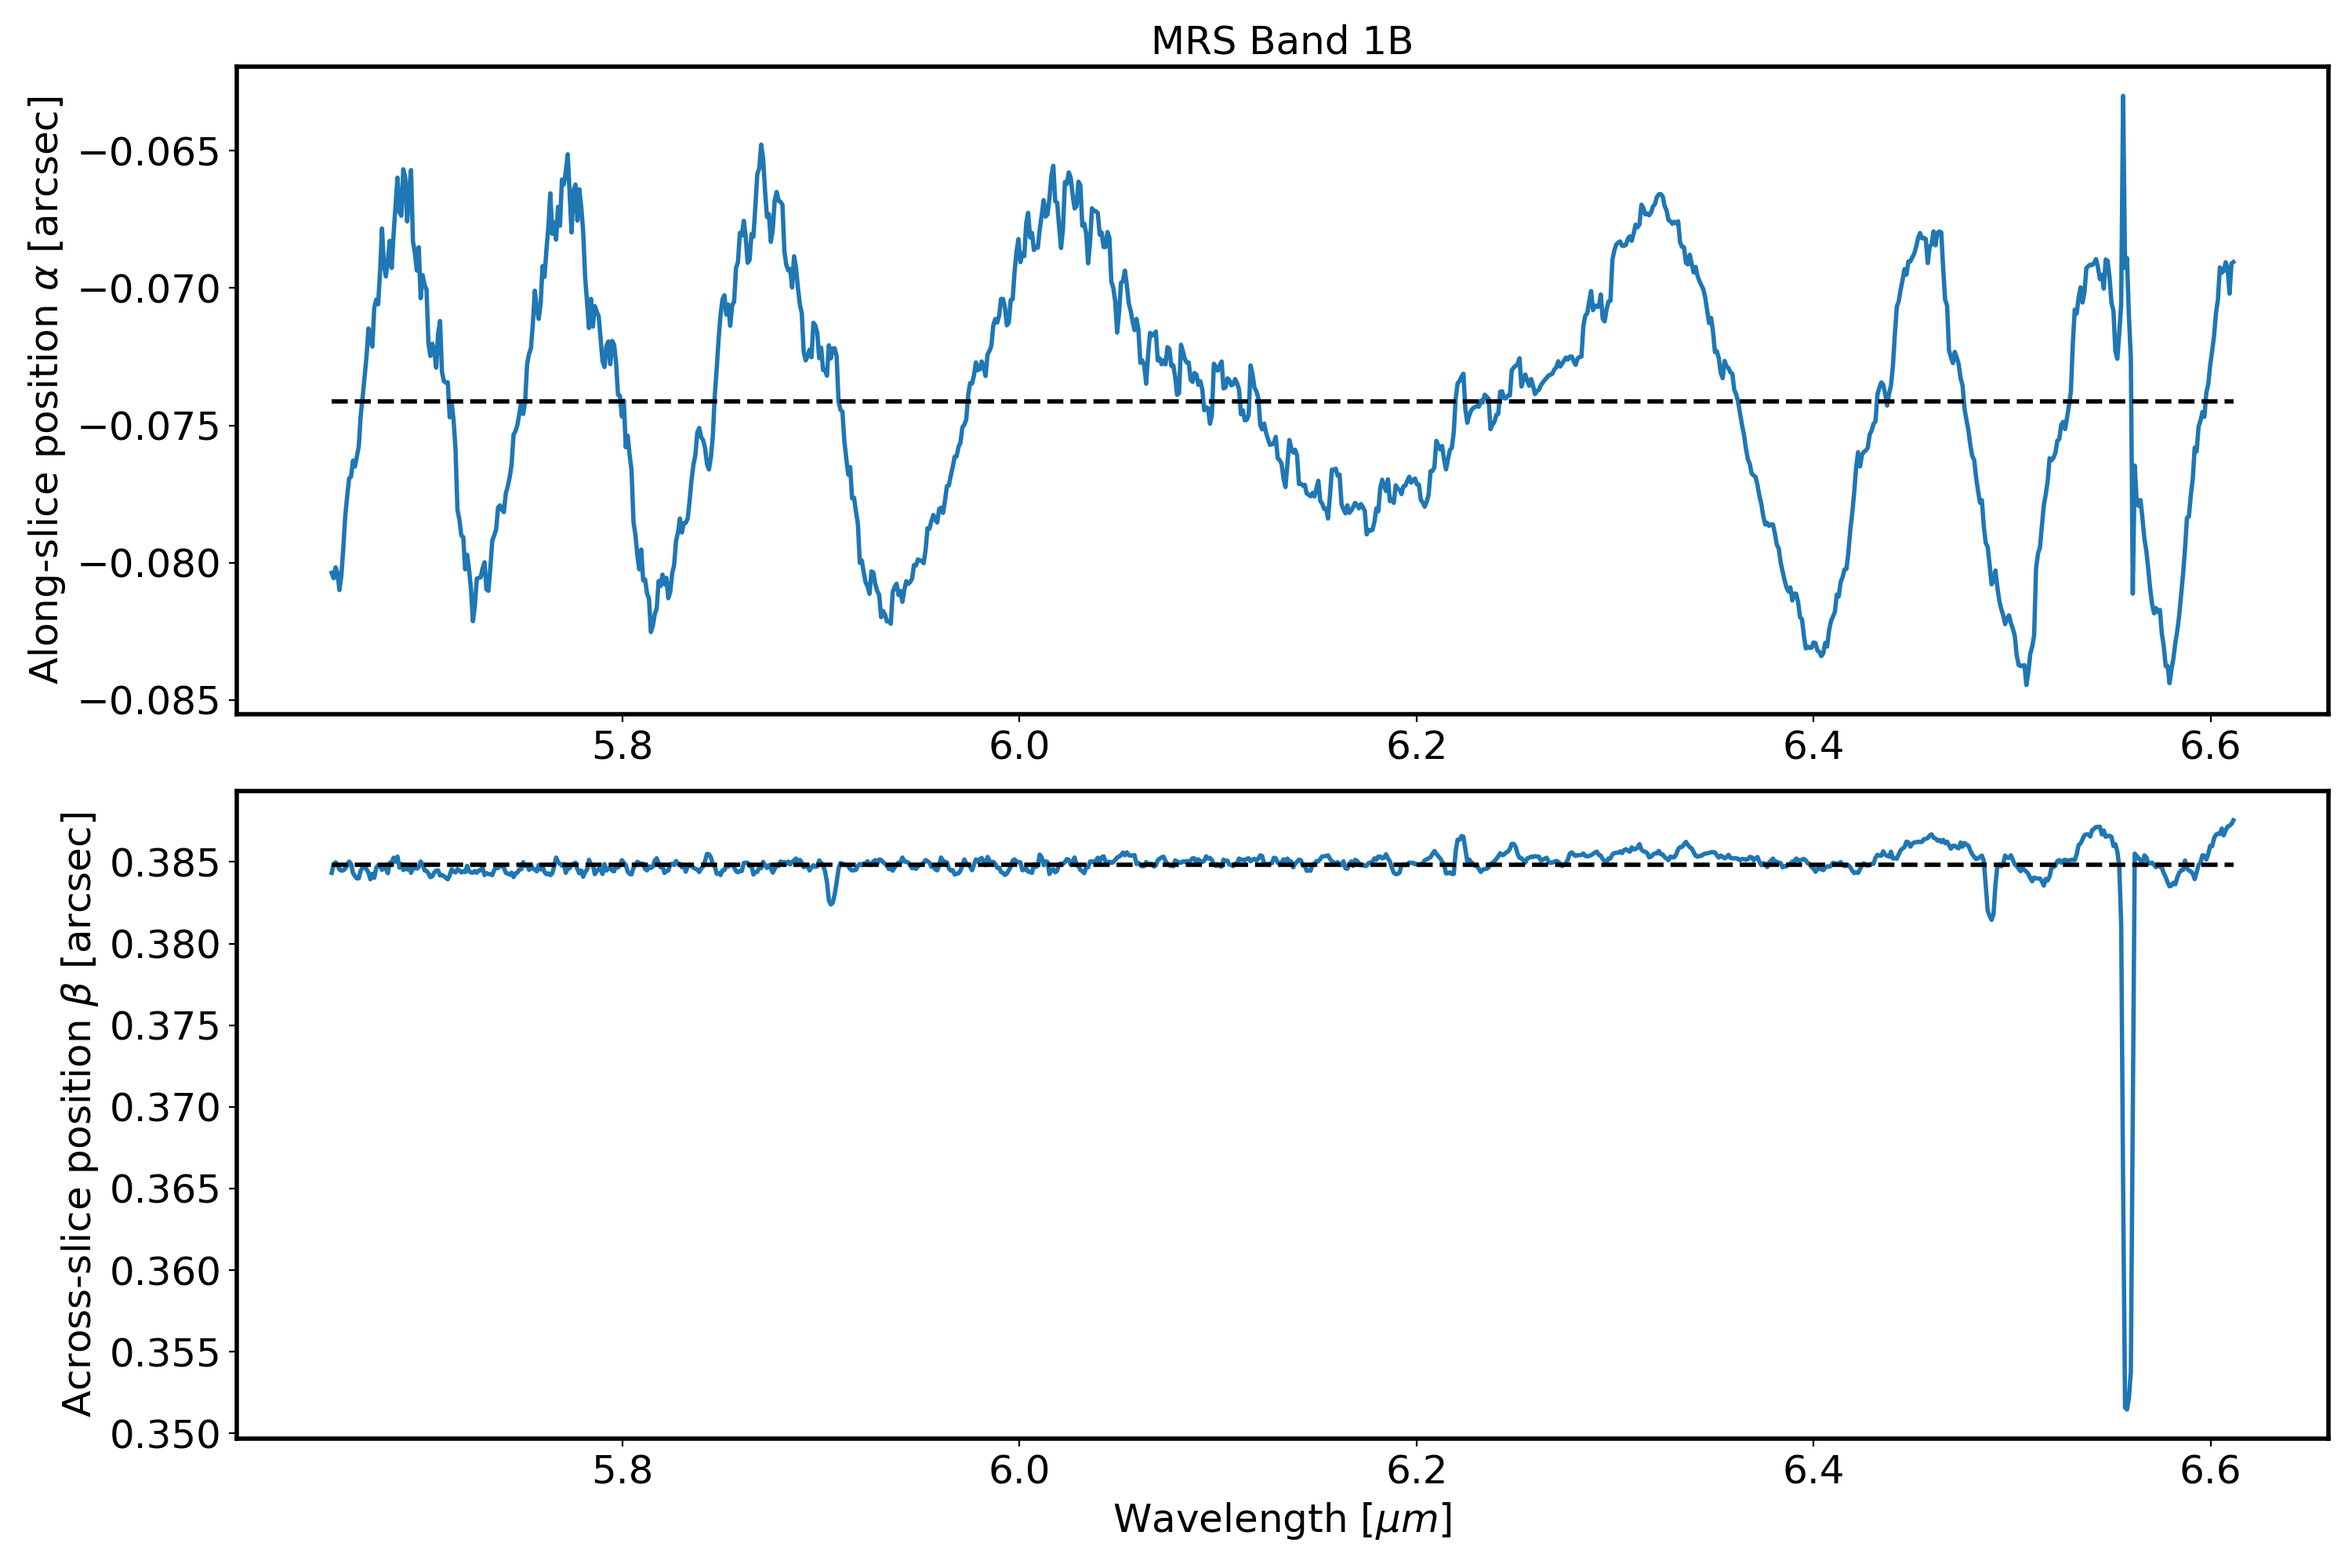

In [13]:
# Diagnostic plot for the point source centroid: We care about the mean value of alpha, beta. These will be used for the PSF projection on the detector plane.
# Conceivably a PSF residual algorithm could be coded, to determine the alpha,beta centroid more accurately still.
fig,axs = plt.subplots(2,1,figsize=(15,10))
axs[0].plot(lambcens[20:-20],alpha_centers2D_dict[band][20:-20])
axs[0].plot(lambcens[20:-20],np.ones(len(lambcens[20:-20]))*np.mean(alpha_centers2D_dict[band][20:-20]),'k--')
axs[1].plot(lambcens[20:-20],beta_centers2D_dict[band][20:-20])
axs[1].plot(lambcens[20:-20],np.ones(len(lambcens[20:-20]))*np.mean(beta_centers2D_dict[band][20:-20]),'k--')
axs[0].set_ylabel(r'Along-slice position $\alpha$ [arcsec]')
axs[0].set_title('MRS Band {}'.format(band))
axs[1].set_xlabel(r'Wavelength [$\mu m$]')
axs[1].set_ylabel(r'Across-slice position $\beta$ [arcsec]')
plt.tight_layout()

# Determine transmission factor corresponding to source across-slice position $\beta$, the signal should be divided by this factor

In [14]:
# CDP values
lamb_min = {'CH1':4.7,'CH2':7.45,'CH3':11.47,'CH4':17.54} # micron
lamb_max = {'CH1':7.76,'CH2':11.87,'CH3':18.24,'CH4':28.82} # micron
Tcen_min = {'CH1':96.7,'CH2':96.2,'CH3':92.2,'CH4':91.9} # percent
Tcen_max = {'CH1':93.3,'CH2':92.2,'CH3':89.8,'CH4':88.9} # percent
Tedg_min = {'CH1':91.0,'CH2':91.9,'CH3':89.0,'CH4':87.0} # percent
Tedg_max = {'CH1':91.6,'CH2':90.5,'CH3':87.3,'CH4':84.7} # percent

In [15]:
beta = np.mean(beta_centers2D_dict[band][20:-20])
wav_array = {}
Tb_min = {}
Tb_max = {}
Tdiff_point = {}
Tdiff_extended = {}
for key in ['CH1','CH2','CH3','CH4']:
    wav_array[key] = np.arange(lamb_min[key],lamb_max[key],0.01) #  micron
    Tb_min[key] = Tcen_min[key] + 2 * abs(beta) * (Tedg_min[key]-Tcen_min[key])
    Tb_max[key] = Tcen_max[key] + 2 * abs(beta) * (Tedg_max[key]-Tcen_max[key])
    
    Tdiff_point[key] = Tb_min[key] + ( (wav_array[key]-lamb_min[key])/(lamb_max[key]-lamb_min[key]) ) * (Tb_max[key]-Tb_min[key])
    Tdiff_extended[key] = (Tcen_min[key]+Tedg_max[key])/2. + ( (wav_array[key]-lamb_min[key])/(lamb_max[key]-lamb_min[key]) ) * ((Tcen_max[key]+Tedg_max[key]) - (Tcen_min[key]+Tedg_min[key])) / 2.

<IPython.core.display.Javascript object>


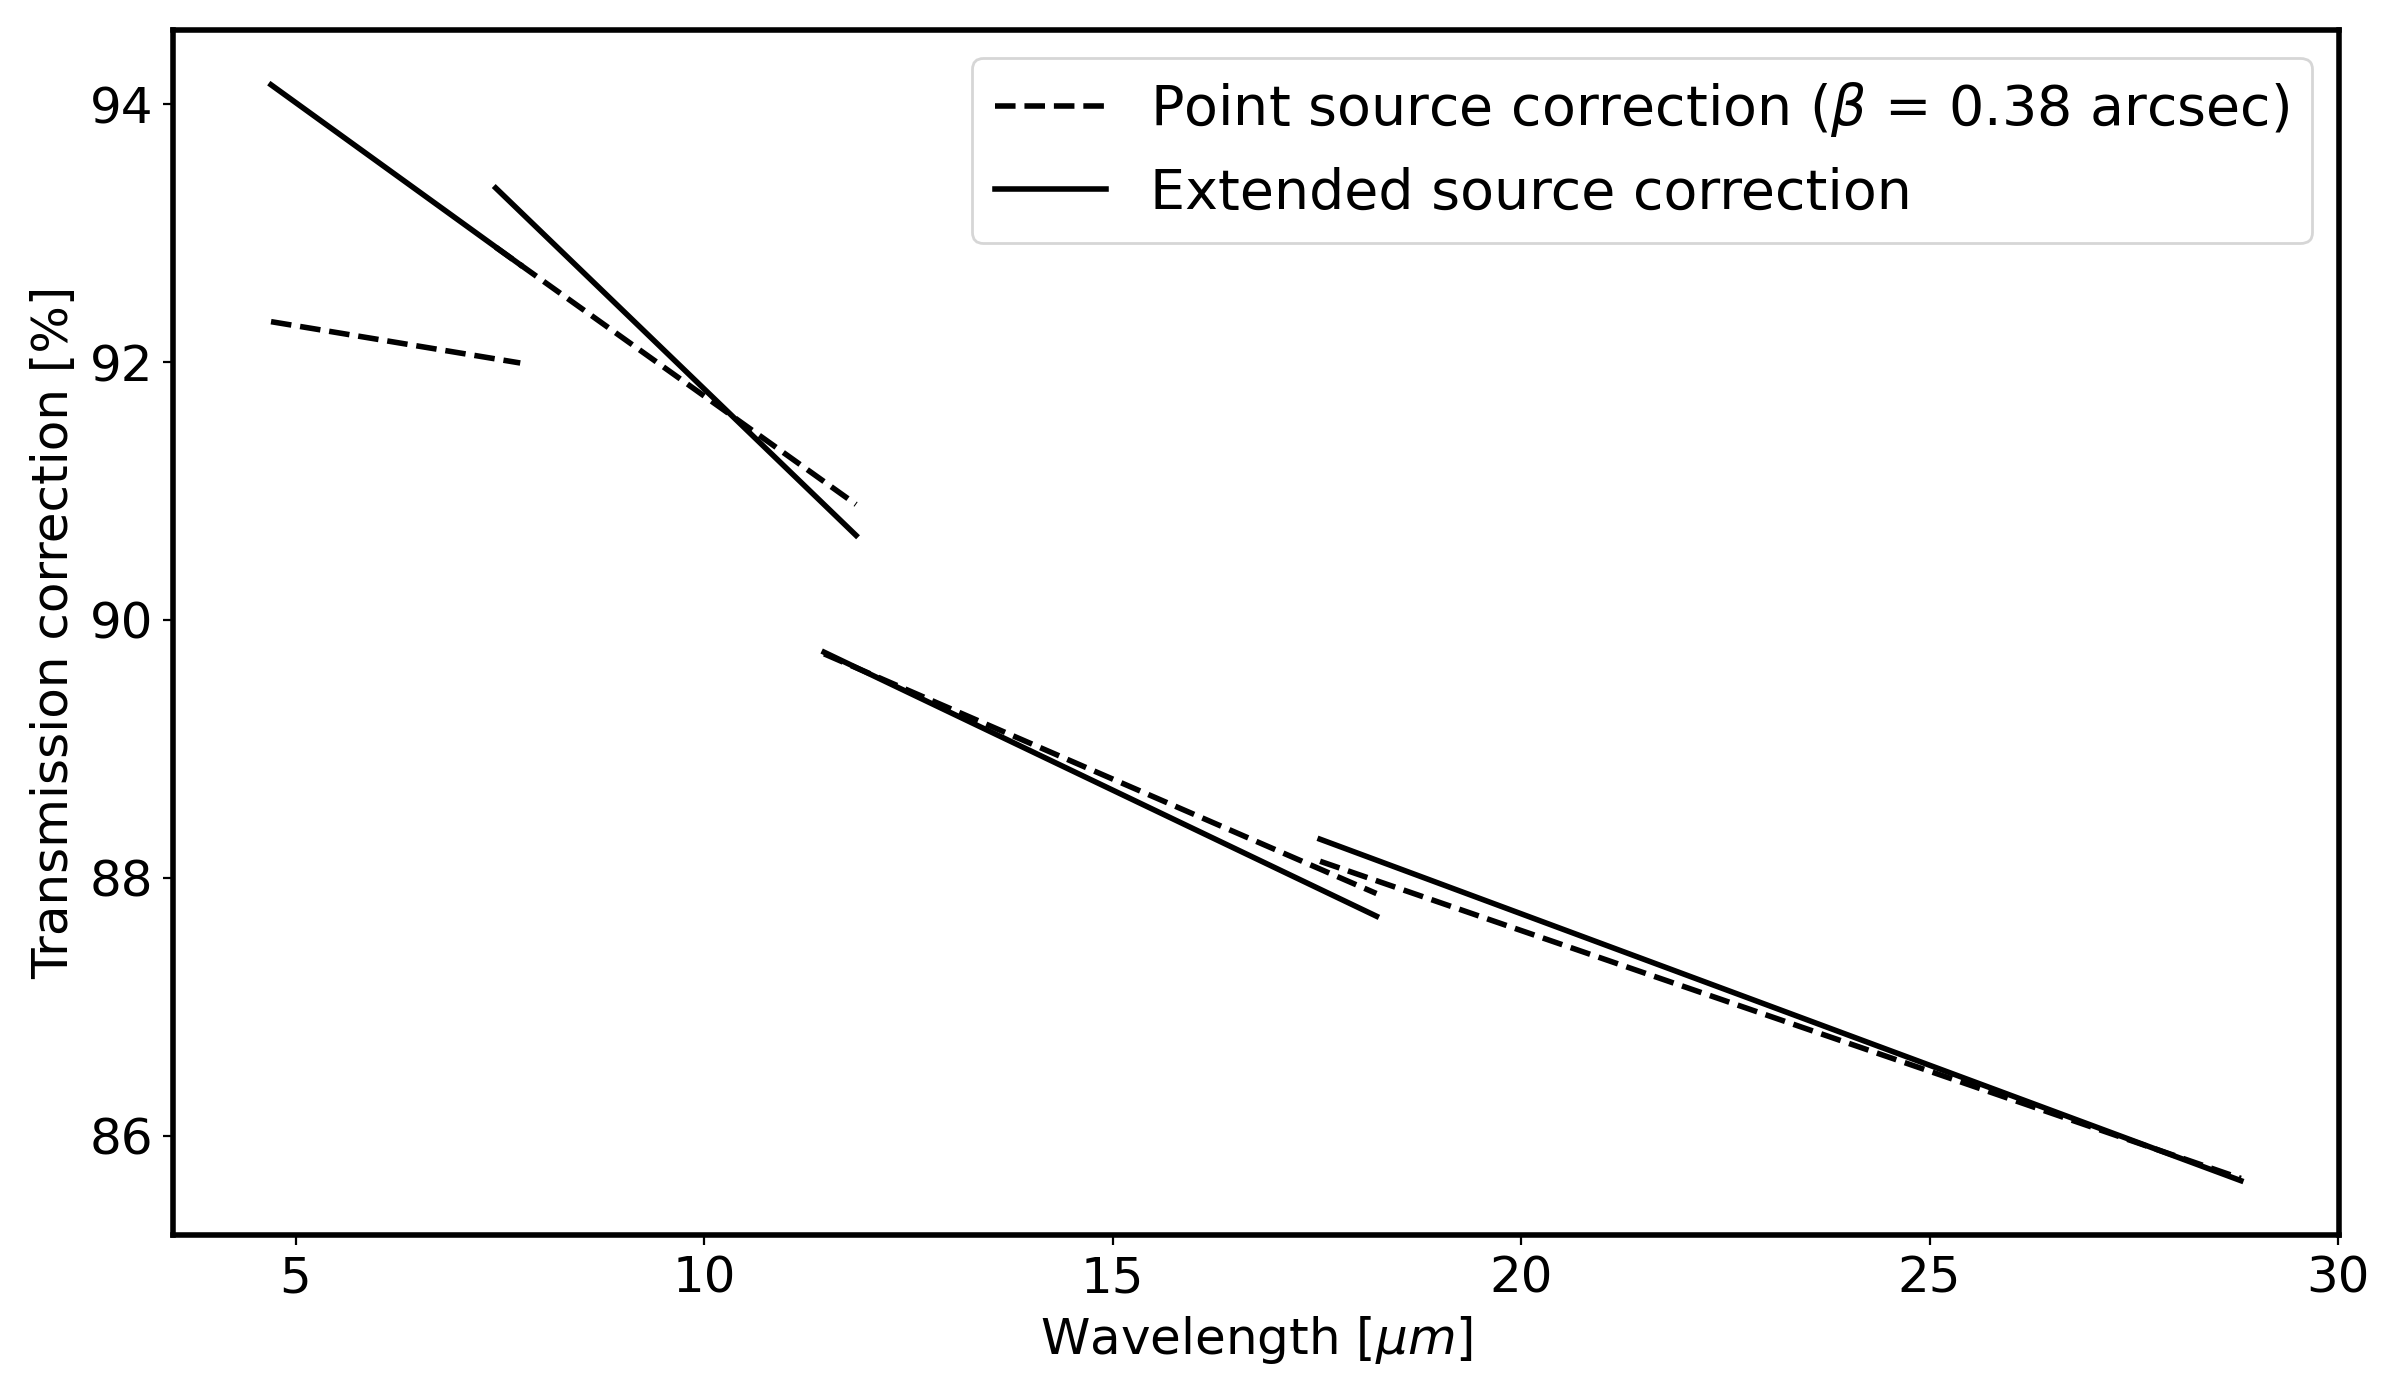

<IPython.core.display.Javascript object>


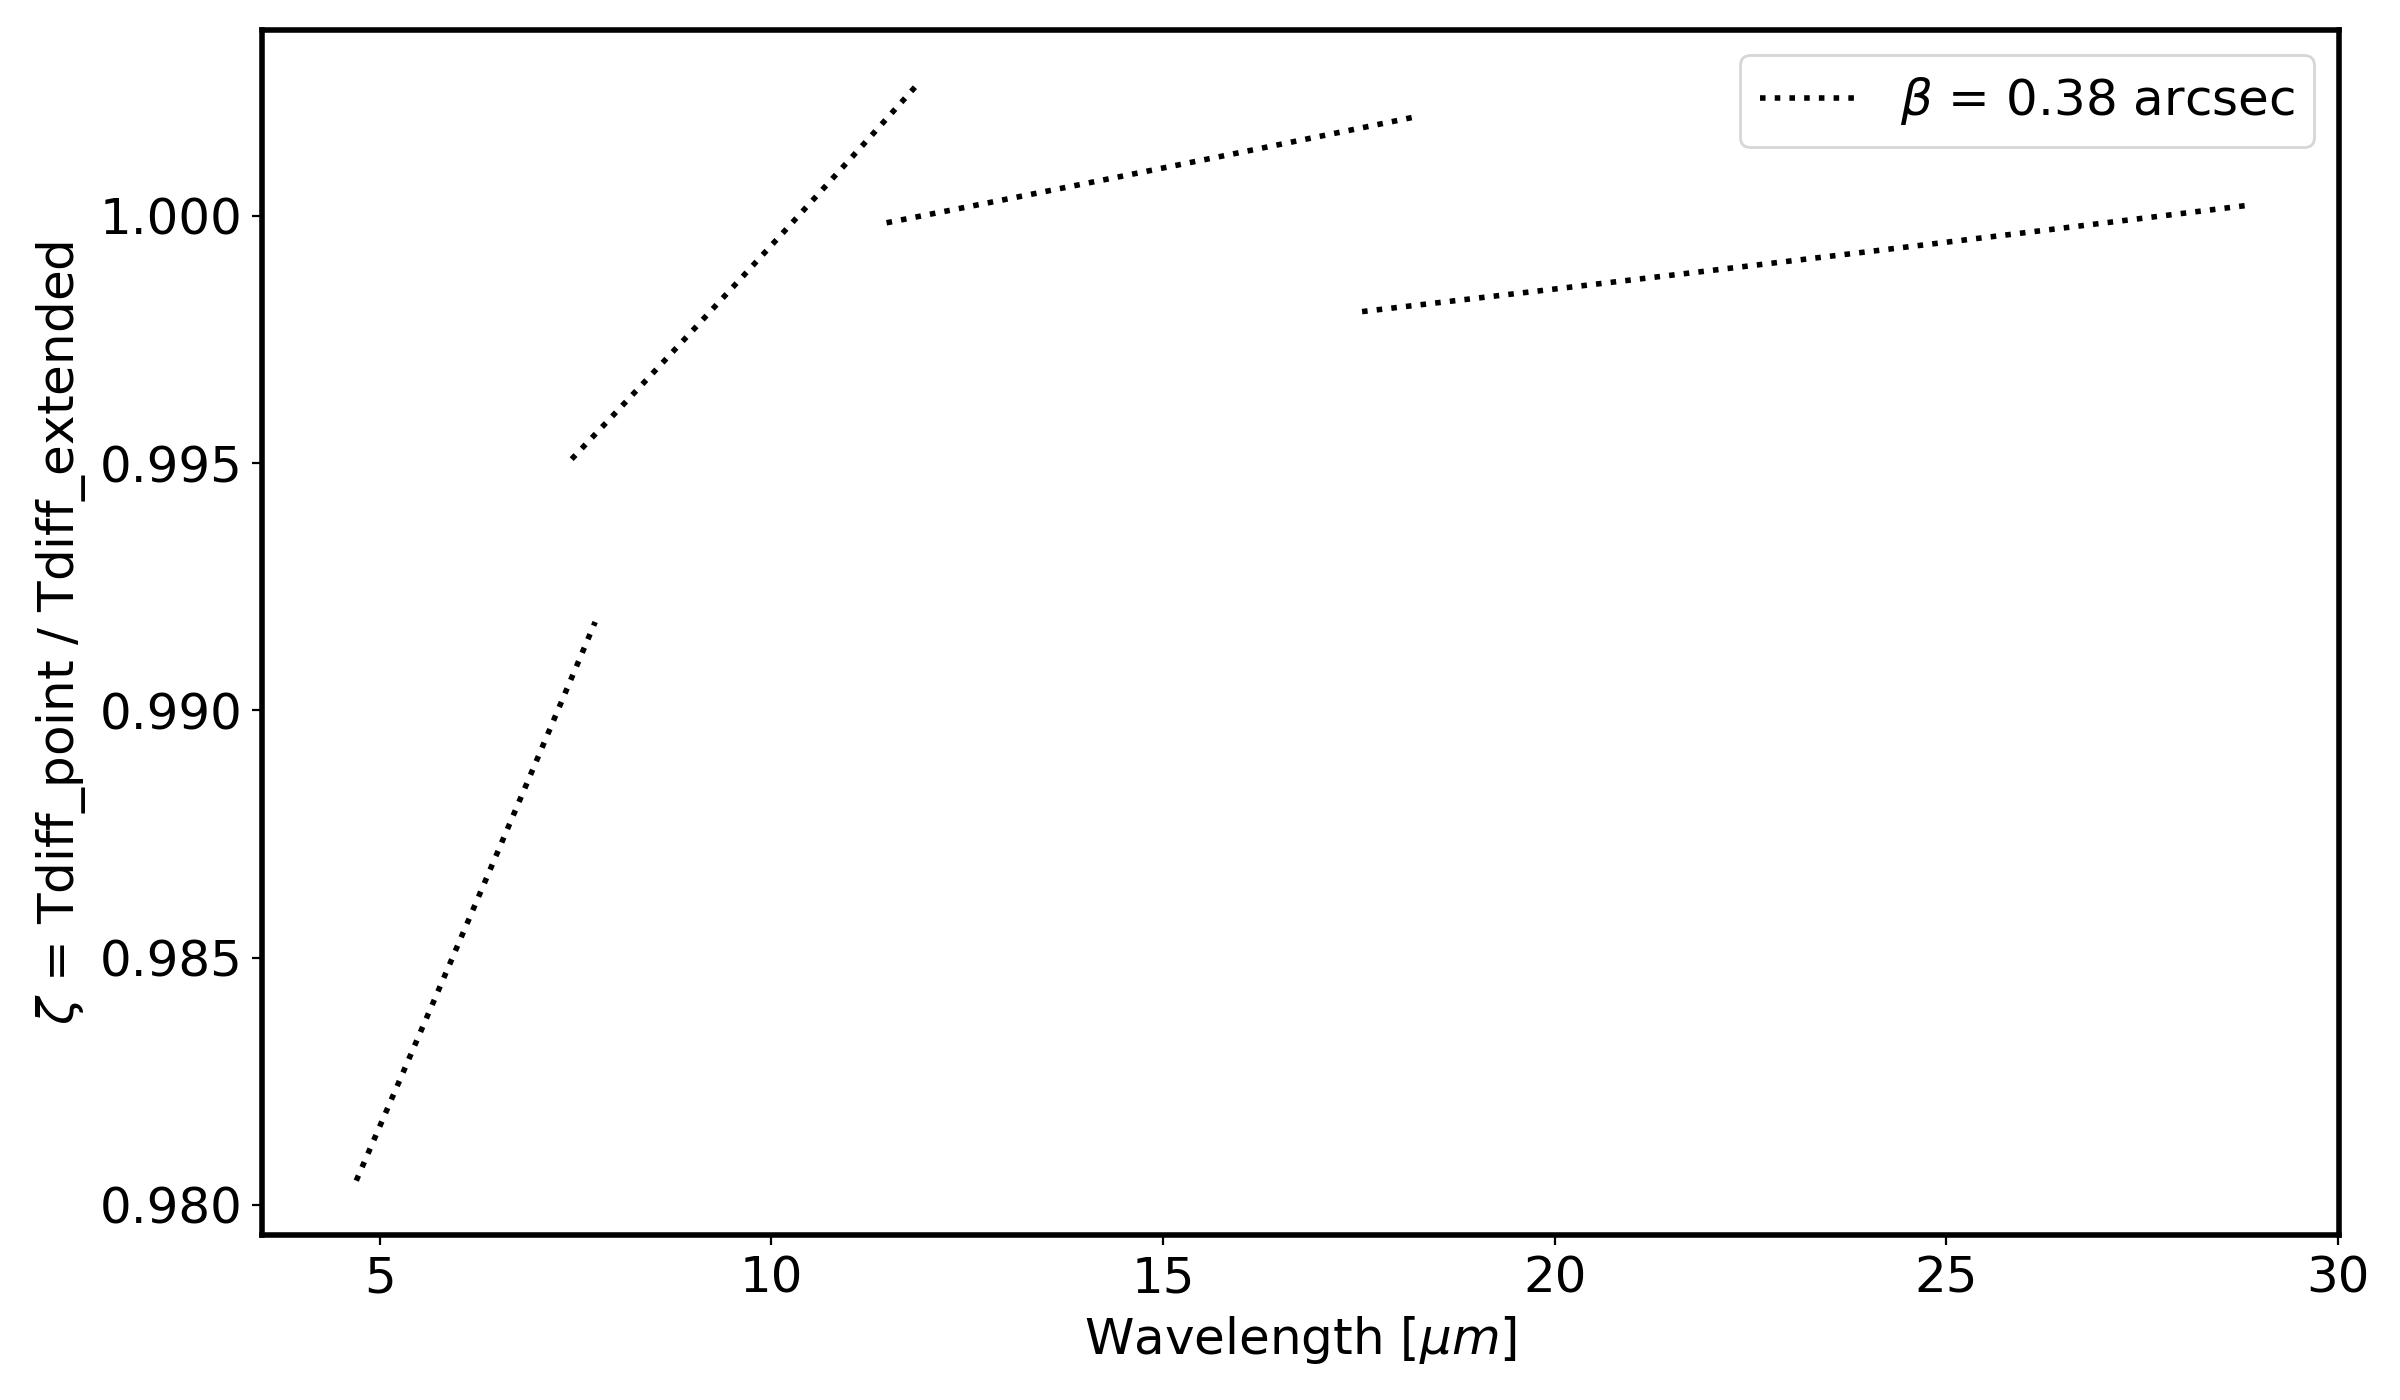

In [16]:
plt.figure(figsize=(12,7))
for key in ['CH1','CH2','CH3','CH4']:
    plt.plot(wav_array[key],Tdiff_point[key],'k',linestyle='dashed')
    plt.plot(wav_array[key],Tdiff_extended[key],'k')
plt.xlabel(r'Wavelength [$\mu m$]')
plt.ylabel(r'Transmission correction [%]')
legend_elements = [Line2D([0],[0],color='k',linestyle='dashed',label=r'Point source correction ($\beta$ = {} arcsec)'.format(np.round(beta,2) )),
                   Line2D([0],[0],color='k',linestyle='solid',label='Extended source correction')]
plt.legend(handles=legend_elements,fontsize=20)
plt.tight_layout()

plt.figure(figsize=(12,7))
for key in ['CH1','CH2','CH3','CH4']:
    plt.plot(wav_array[key],Tdiff_point[key]/Tdiff_extended[key],'k',linestyle='dotted')
plt.xlabel(r'Wavelength [$\mu m$]')
plt.ylabel(r'$\zeta$ = Tdiff_point / Tdiff_extended')
legend_elements = [Line2D([0],[0],color='k',linestyle='dotted',label=r'$\beta$ = {} arcsec'.format(np.round(beta,2)))]
plt.legend(handles=legend_elements)
plt.tight_layout()

<IPython.core.display.Javascript object>


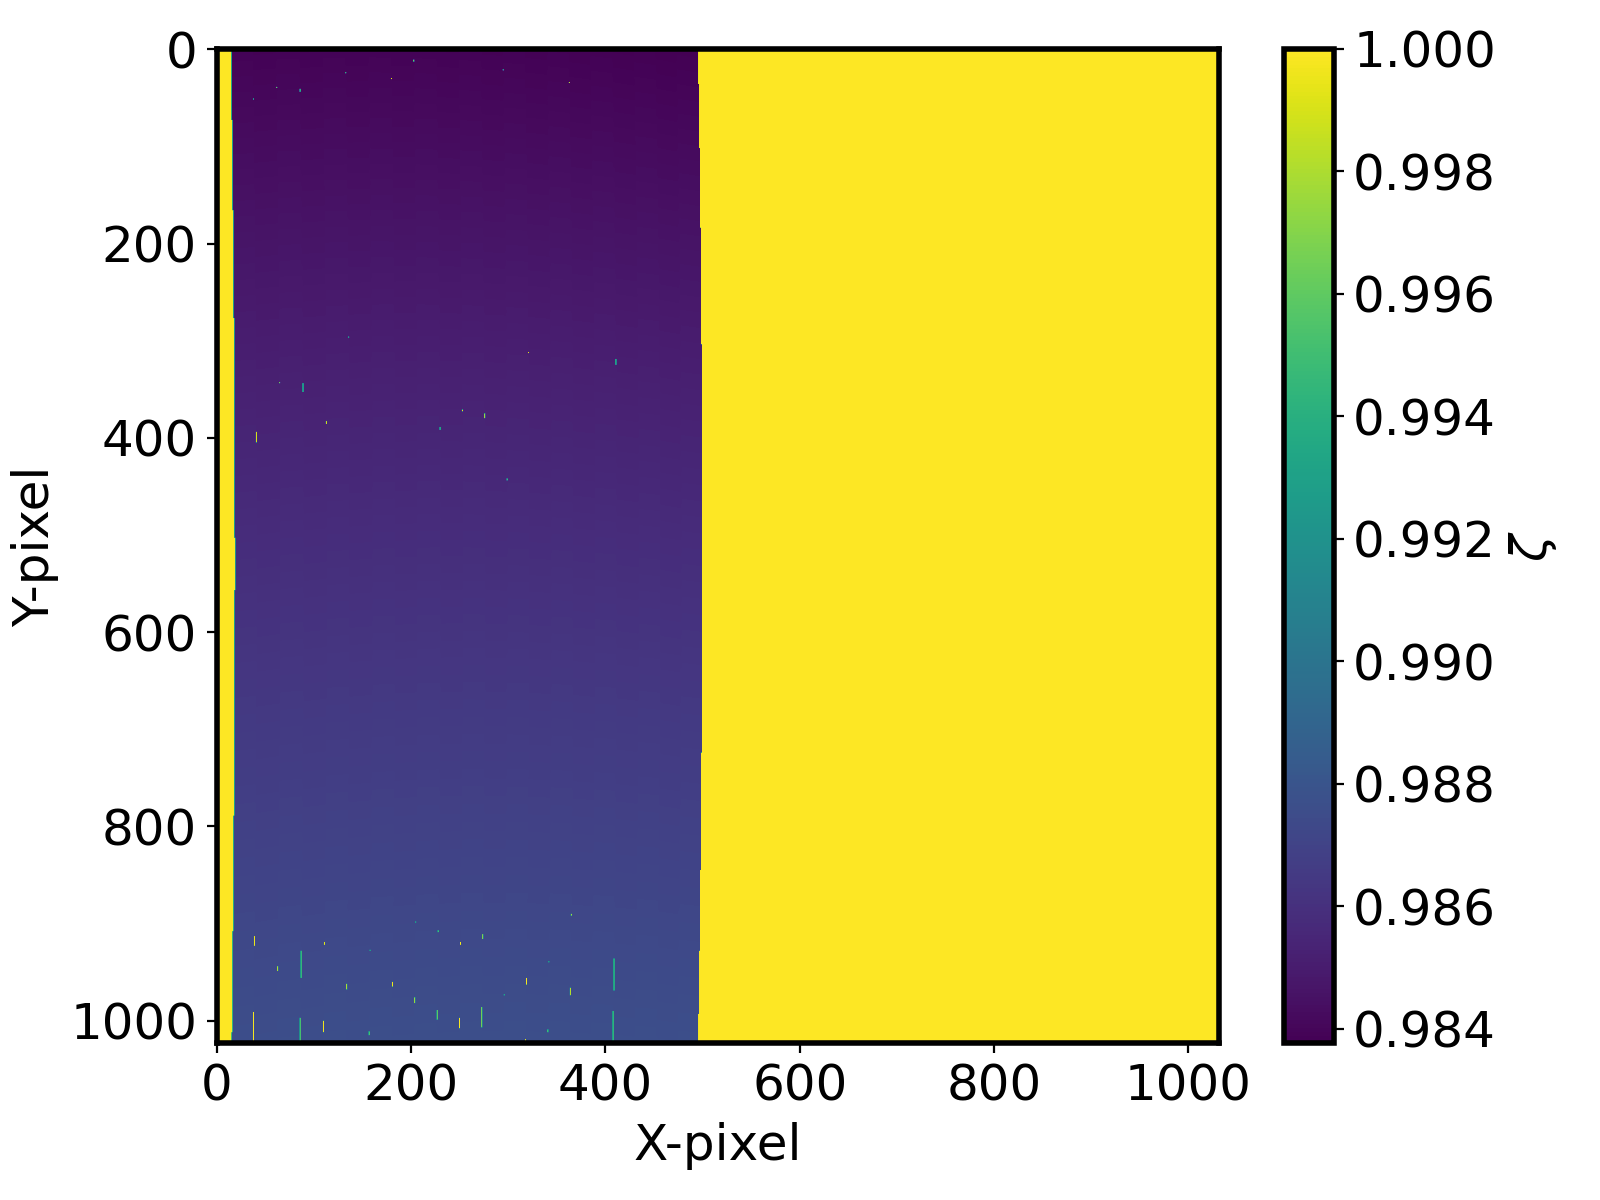

In [17]:
key = 'CH'+band[0]
ip_zeta = interp1d(wav_array[key], Tdiff_point[key]/Tdiff_extended[key], kind='linear')

zetaMap = np.ones(lambdaMap.shape)
sel = (sliceMap>100*int(band[0])) & (sliceMap<100*(int(band[0])+1) )
zetaMap[sel] = ip_zeta(lambdaMap[sel])

plt.figure(figsize=(8,6))
plt.imshow(zetaMap,vmin=zetaMap[zetaMap!=0].min(),vmax=zetaMap[zetaMap!=0].max())
clb = plt.colorbar()
clb.set_label(r'$\zeta$')
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.tight_layout()

In [18]:
# Apply correction to science and error signal
sci_img /= zetaMap
err_img /= zetaMap

# Determine wavelength correction due to source across-slice position $\beta$

<IPython.core.display.Javascript object>


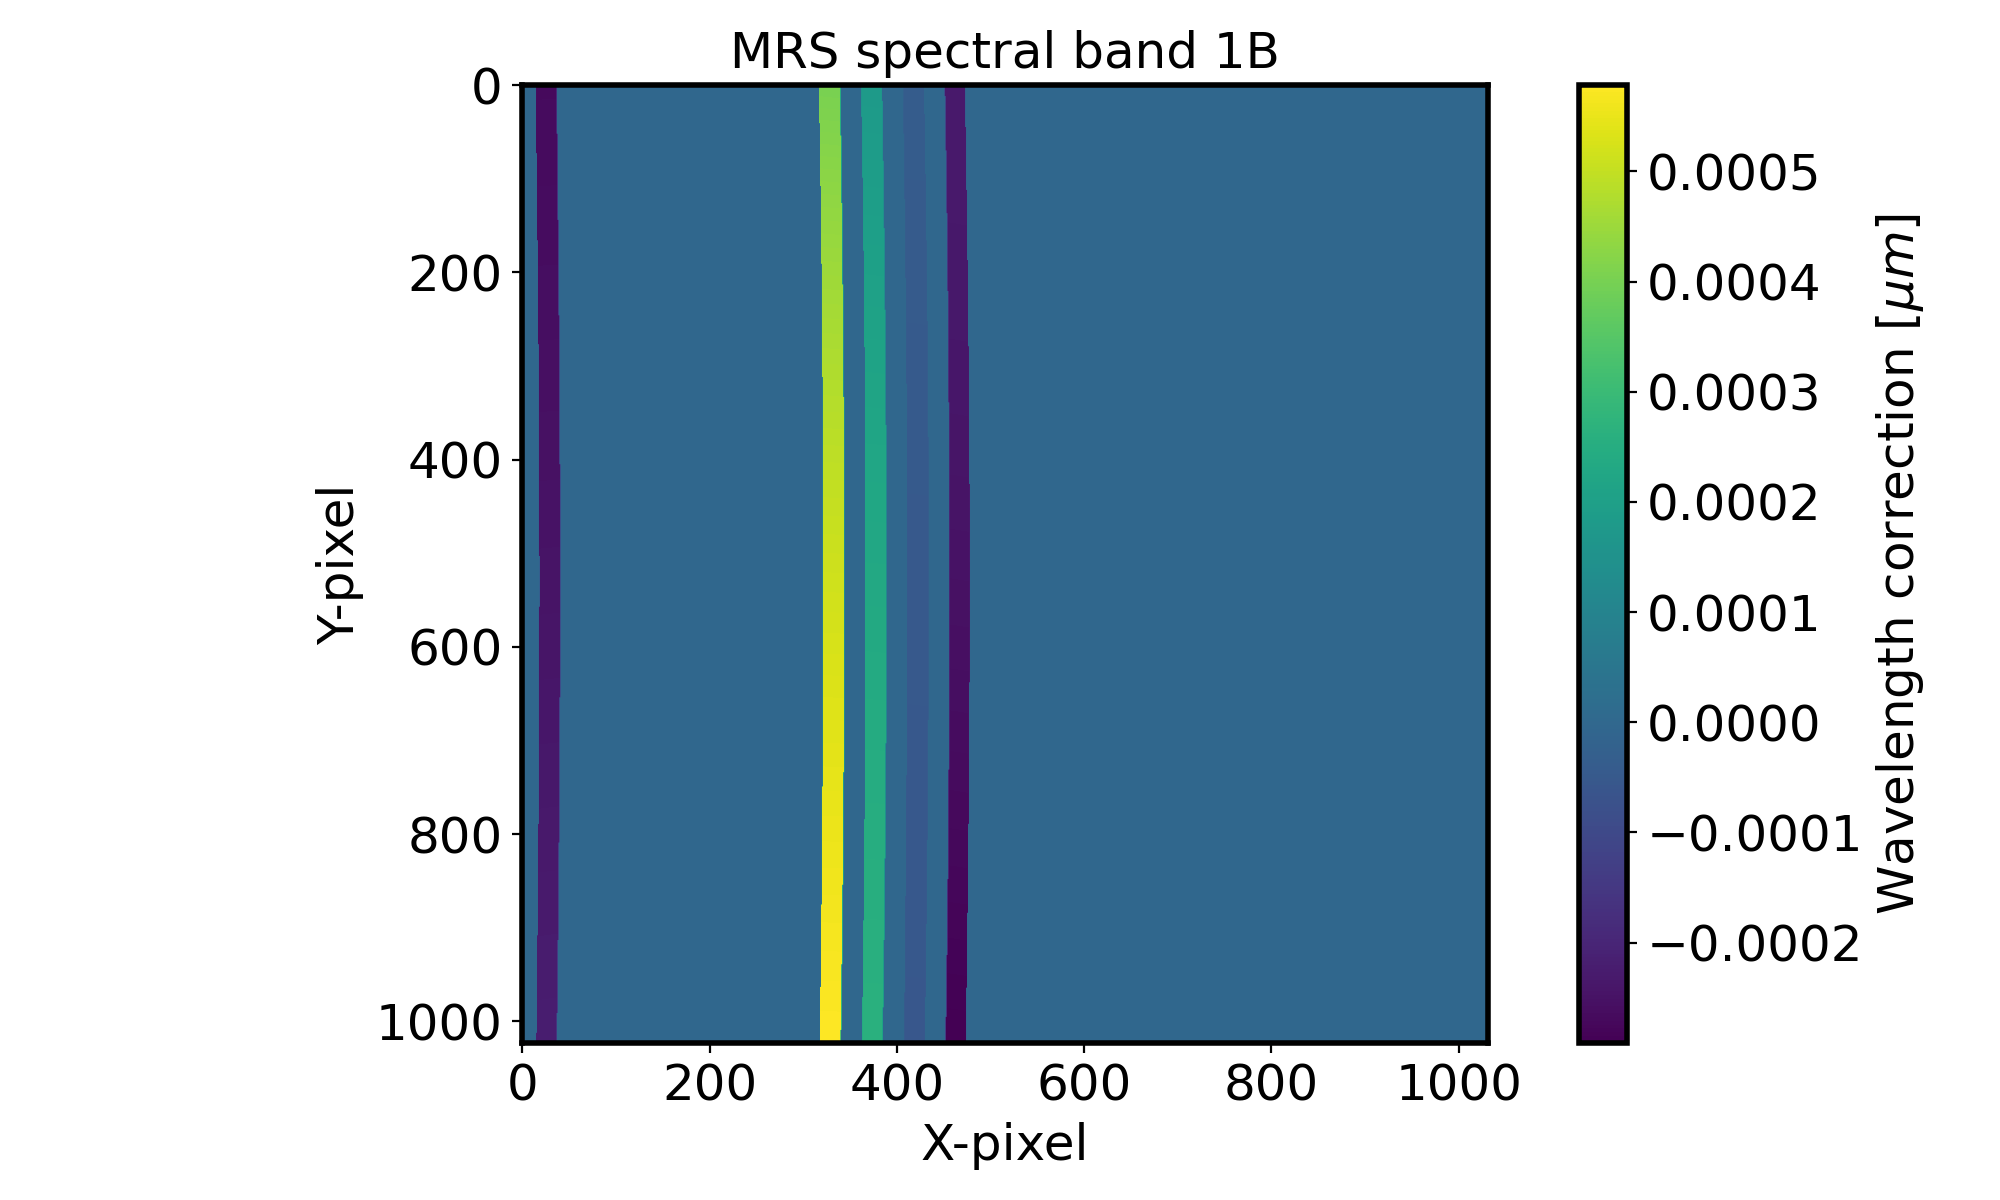

In [19]:
beta_center = np.mean(beta_centers2D_dict[band][20:-20])

# determine unique beta values for each slice
sel = np.where((sliceMap > 100*int(band[0])) & (sliceMap < 100*(int(band[0])+1)))
unique_betas = np.unique(betaMap[sel])

# find index of value nearest to beta center in the unique_betas array
idx = np.abs(unique_betas-beta_center).argmin() 
source_center_slice = idx+1

# find index of value nearest to beta center in the unique_betas array
beta_brightest_slice = unique_betas[idx]

# Point source offset from slice centre (-0.5 < tgtOffset < +0.5)
betaOffsetSlice0 = (beta_center-beta_brightest_slice)/d2cMaps['bdel'] 

# CDP values for correction
hdu = fits.open(cdpDir+'WAVECORR/MIRI_FM_{}_{}_WAVCORR_06.00.00.fits'.format(det_id,band_combo))

bands = list(hdu['WAVCORR_OPTICAL'].data['SUB_BAND'])
x_slice_min_LT,x_slice_max_LT = hdu['WAVCORR_XSLICE'].data[0]  # micron * arcsec^-1
beta_slice = hdu['WAVCORR_OPTICAL'].data['BETA_SLICE']
wave_min = hdu['WAVCORR_OPTICAL'].data['WAVE_MIN']
wave_max = hdu['WAVCORR_OPTICAL'].data['WAVE_MAX']
srp_min = hdu['WAVCORR_OPTICAL'].data['SRP_MIN']
srp_max = hdu['WAVCORR_OPTICAL'].data['SRP_MAX']

beta_off = hdu['WAVCORR_SHIFT'].data['BETA_OFF']
Delta_s_min_LT = hdu['WAVCORR_SHIFT'].data['DS_MIN']
Delta_s_max_LT = hdu['WAVCORR_SHIFT'].data['DS_MAX']
hdu.close()

# Define input data characteristics.
nSubBands = 3
optIndex = nSubBands * (int(band[0]) - 1) + (band_id_nr - 1)
betaSlice = beta_slice[optIndex]

# Compute wavelength correction map (based on MIRI-DD-00006-ATC issue 4)
# The correction is valid only for the two slices nearest to the brightest slice
wavcorr_across_slice = np.zeros((1024,1032))
for islice in range(-2, 3):
    sel = (sliceMap == 100*int(band[0])+source_center_slice+islice)
    tgtWave = lambdaMap[sel]
    
    # Step 1. Find target offset from slice centre in beta direction'
    betaOff = betaOffsetSlice0 - islice

    # Step 2. Calculate Xslice
    xSlice = betaSlice / tgtWave
    xSliceref = betaSlice / ((lambmin+lambmax)/2.) # We define a reference xslice for the entire band to avoid jumps between beta_off values as a function of wavelength in Step 4.

    # Step 3. Derive scaled offset
    betaOff_scaled = betaOff * xSlice
    betaOff_scaled_ref = betaOff * xSliceref  # We define a reference betaOff_scaled_ref for the entire band to avoid jumps between beta_off values as a function of wavelength in Step 4.

    # Step 4. Find look-up table betaOff_LT values which bracket betaOFF_scaled
    nShiftValues = len(beta_off)
    betaSign = 1
    if (betaOff < 0.0):
        betaSign = -1
        betaOff_scaled = -1.0 * betaOff_scaled
    indexA = -1 # Index in look up table_WCORR_SHIFT 
    for j in range(nShiftValues):
        if (betaOff_scaled_ref < beta_off[j]):
            if (indexA == -1):
                indexA = j-1
    indexB = indexA + 1
    betaOff_LT_A = beta_off[indexA]
    betaOff_LT_B = beta_off[indexB]

    # Step 5. Find ds_min and ds_max
    betaFactor = (betaOff_scaled - betaOff_LT_A) / (betaOff_LT_B - betaOff_LT_A) 

    ds_minA = Delta_s_min_LT[indexA]
    ds_minB = Delta_s_min_LT[indexB]
    ds_min = ds_minA + betaFactor * (ds_minB - ds_minA)
    ds_min = betaSign * ds_min

    ds_maxA = Delta_s_max_LT[indexA]
    ds_maxB = Delta_s_max_LT[indexA]
    ds_max = ds_maxA + betaFactor * (ds_maxB - ds_maxA)
    ds_max = betaSign * ds_max

    # Step 6. Find ds by interpolation between ds_min and ds_max
    xSlice_min = x_slice_min_LT
    xSlice_max = x_slice_max_LT
    xFactor = (xSlice - xSlice_min) / (xSlice_max - xSlice_min)

    ds = ds_min + xFactor * (ds_max - ds_min)

    # Step 7. Convert ds to wavelength shift by intepolstion between SRP values
    w_min = wave_min[optIndex]
    w_max = wave_max[optIndex]
    wFactor = (tgtWave - w_min) / (w_max - w_min)

    srp = srp_min[optIndex] + wFactor * (srp_max[optIndex] - srp_min[optIndex])

    wavcorr_across_slice[sel] = ds * tgtWave / srp

# Plot wavelength correction map
plt.figure(figsize=(10,6))
plt.imshow(wavcorr_across_slice)
clb = plt.colorbar()
clb.set_label('Wavelength correction [$\mu m$]')
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.title('MRS spectral band {}'.format(band))
plt.tight_layout()

In [20]:
# Apply correction to wavelength map
lambdaMap += wavcorr_across_slice

# Load MRS PSF model in the 3D spectral cube and project it on the 2D detector

In [21]:
psf_fits_file = cdpDir+"MIRI_FM_{}_{}{}_PSF_07.02.00.fits".format(det_id,ch,band_id.upper())
psffits = fits.open(psf_fits_file)

# normalize and project PSF on 2D detector (normalization ensures that each cube slice of the model has a signal sum of 1)
psf_img = evaluate_psf_cdp(psffits,d2cMaps,source_center=[np.mean(alpha_centers2D_dict[band][20:-20]),np.mean(beta_centers2D_dict[band][20:-20])],norm=True)

# close fits file
psffits.close()

Normalizing PSF (divide by sum of all spaxel values)
DONE


<IPython.core.display.Javascript object>


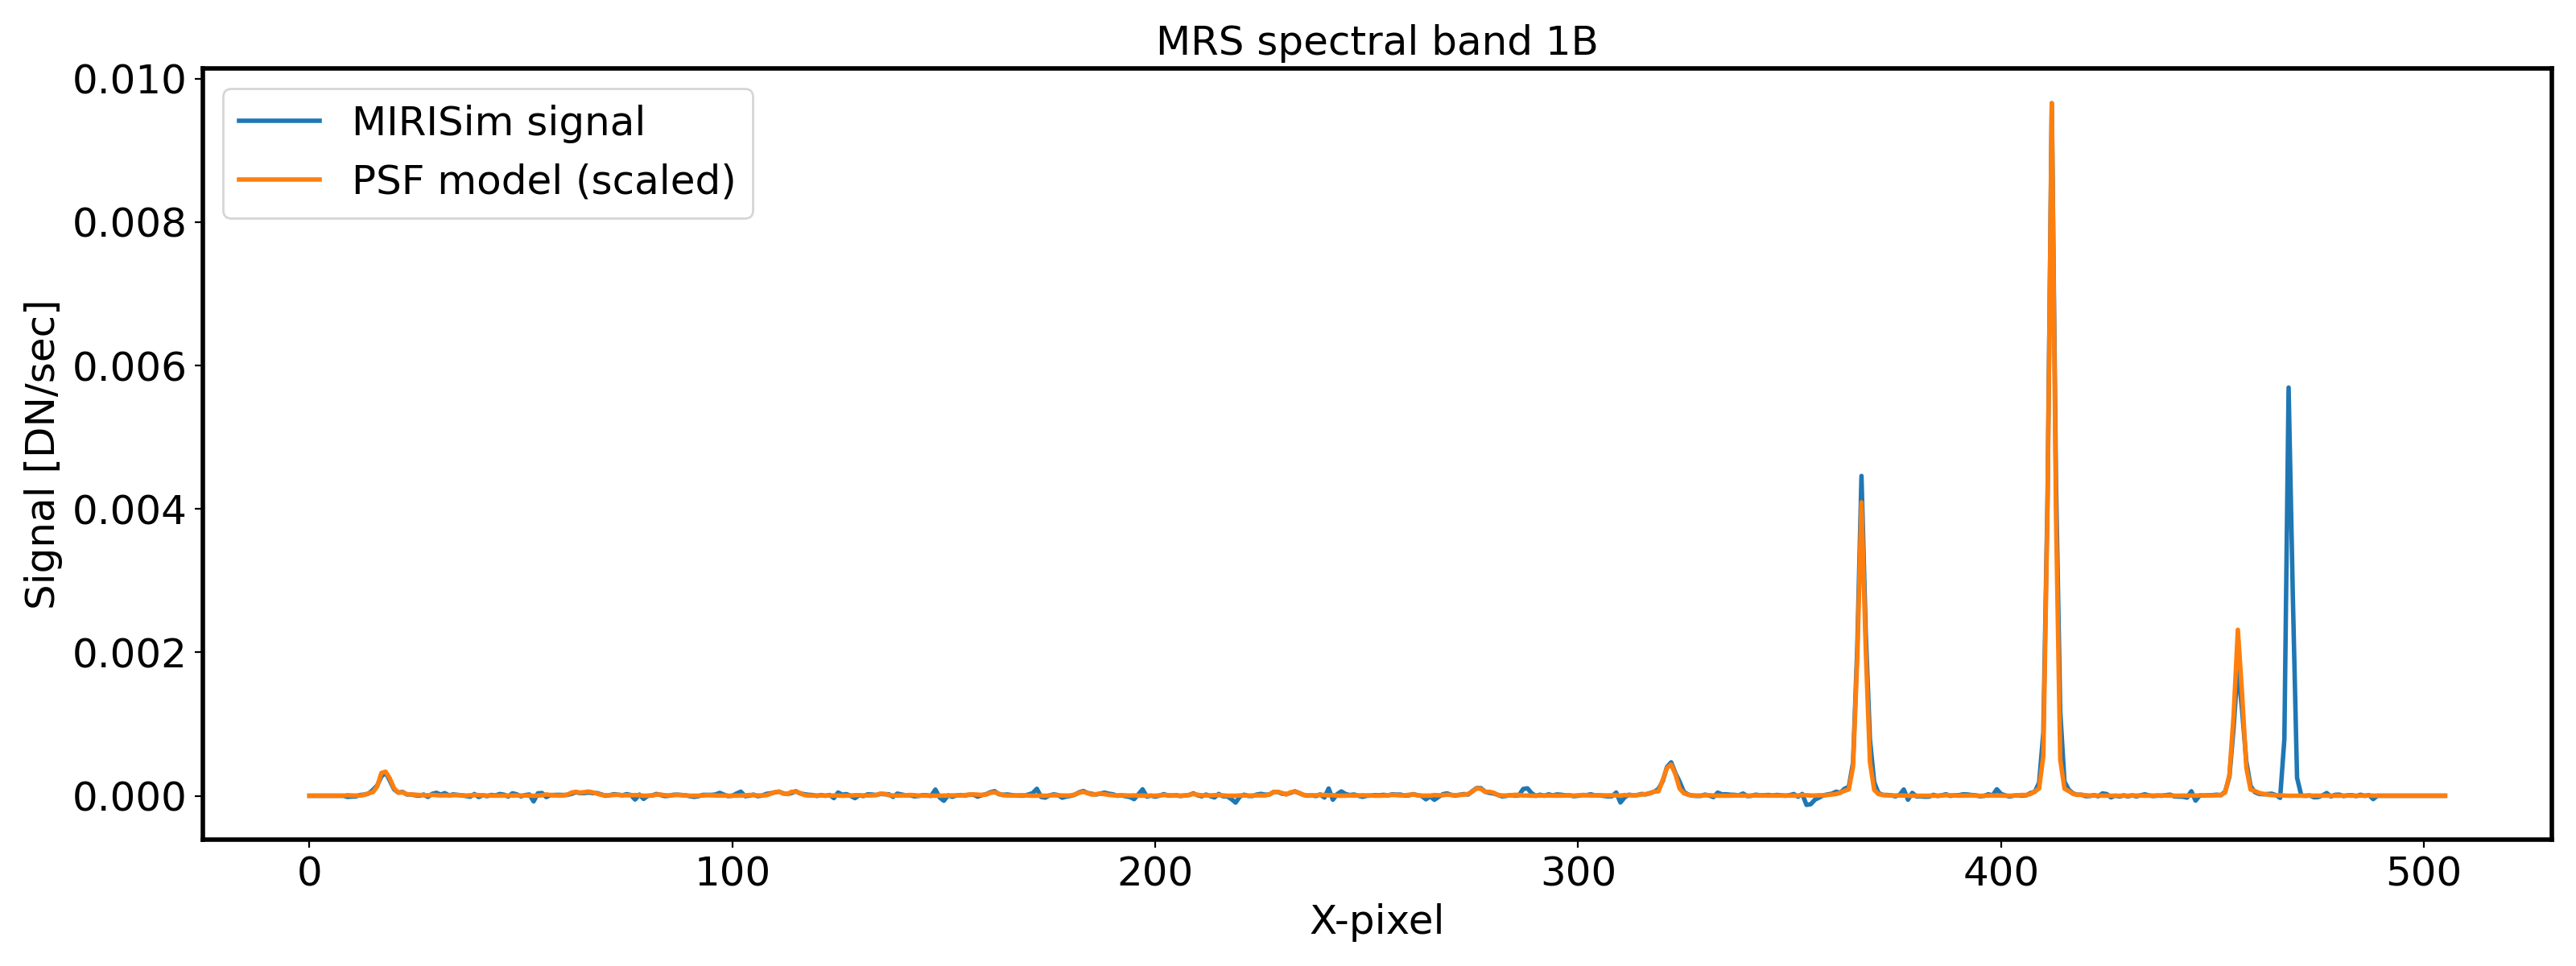

In [22]:
# Diagnostic plot to show how well the projected PSF matches the data
# For low SNR observations this will likely not be very useful
plt.close('all')
plt.figure(figsize=(16,6))
if band[0] in ['1','4']:
    plt.plot(sci_img[512,10:516],label='MIRISim signal')
    scale_factor = (sci_img[512,10:516][~np.isnan(sci_img[512,10:516])].max()/psf_img[512,10:516].max())
    plt.plot(psf_img[512,10:516]*scale_factor,label='PSF model (scaled)')
elif band[0] in ['2','3']:
    plt.plot(sci_img[512,516:-10],label='MIRISim signal')
    scale_factor = (sci_img[512,516:-10][~np.isnan(sci_img[512,516:-10])].max()/psf_img[512,516:-10].max())
    plt.plot(psf_img[512,516:-10]*scale_factor,label='PSF model (scaled)')
plt.xlabel('X-pixel')
plt.ylabel('Signal [DN/sec]')
plt.legend()
plt.title('MRS spectral band {}'.format(band))
plt.tight_layout()

In [23]:
# Determine optimal pixel weights for detector-based spectral extraction
weight_map = psf_img**2 / (err_img)**2

In [24]:
# Wavelength array used for the detector-based spectral extraction
# The grid step is approximately half the smallest spectral size in each band (due to the MRS distortion and slice curvature, different pixels contribute to each bin)
wav_array = {'1A':np.arange(4.9,5.74,0.0005),'1B':np.arange(5.67,6.6,0.0008),'1C':np.arange(6.45,7.5,0.001),
             '2A':np.arange(7.477,8.765,0.0014),'2B':np.arange(8.711,10.228,0.0017),'2C':np.arange(10.017,11.753,0.002),
             '3A':np.arange(11.481,13.441,0.0023),'3B':np.arange(13.319,15.592,0.0026),'3C':np.arange(15.4,18.072,0.0030),
             '4A':np.arange(17.651,20.938,0.0036),'4B':np.arange(20.417,24.22,0.0042),'4C':np.arange(23.884,28.329,0.0048)}
nwavs = len(wav_array[band])

# Evaluate smallest distortion solution on the 2D detector (largest slice transmission of 90%)
slice_transmission = '90pc'
d2cMaps   = d2cMapping(band,d2cDir,slice_transmission=slice_transmission,fileversion = "8B.05.02")
lambdaMap = d2cMaps['lambdaMap']
lambdas   = lambdaMap[np.nonzero(lambdaMap)].flatten()

# Need approximate number of pixels contributing to each spectral bin
# This is because only one pixel is used for each detector column --> we want to avoid sampling issues
if band[0] in ['1','2']:
    if slice_transmission == '90pc':
        npix=380
    elif slice_transmission == '10pc':
        npix=500
elif band[0] in ['3','4']:
    npix = 380
k = np.arange(npix)

# Define pixel grid
X,Y = np.meshgrid(np.arange(1032),np.arange(1024))
X_flat = X[np.nonzero(lambdaMap)].flatten()
Y_flat = Y[np.nonzero(lambdaMap)].flatten()

# Omit NaNs from analysis
nan_idx = (np.isnan(sci_img)==False)

<IPython.core.display.Javascript object>


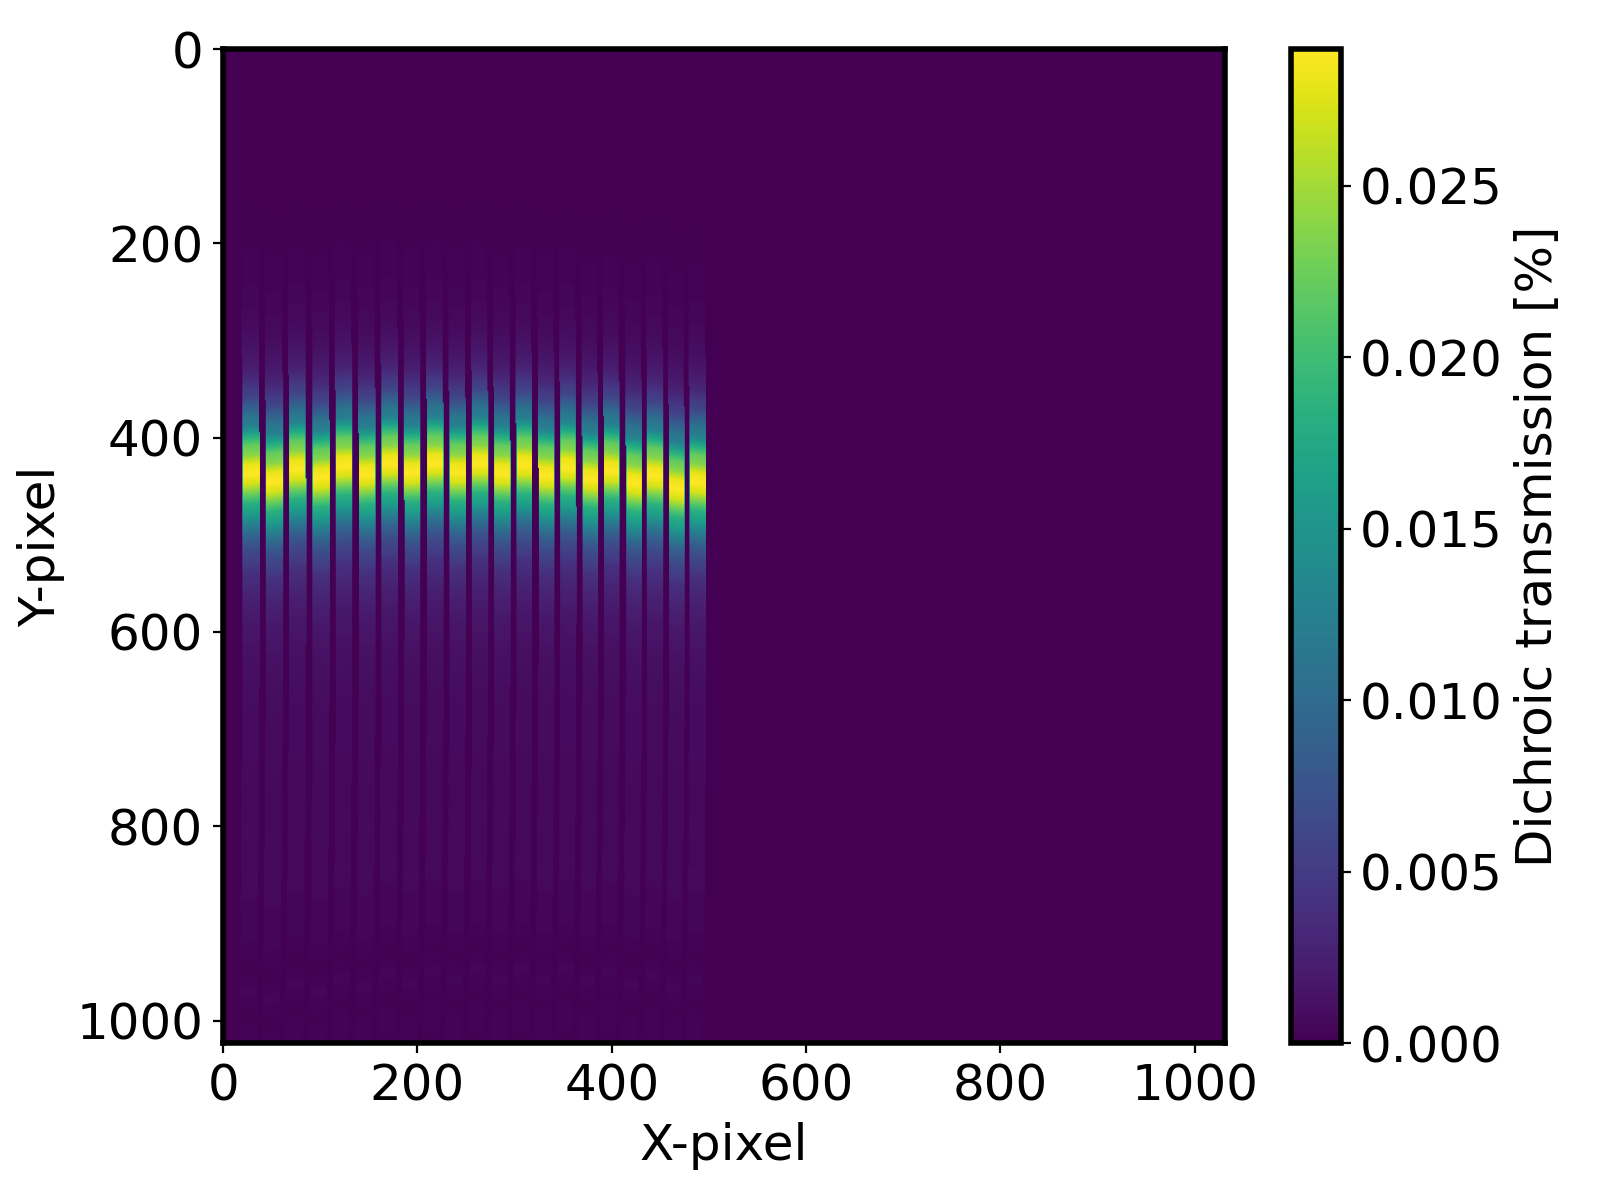

<IPython.core.display.Javascript object>


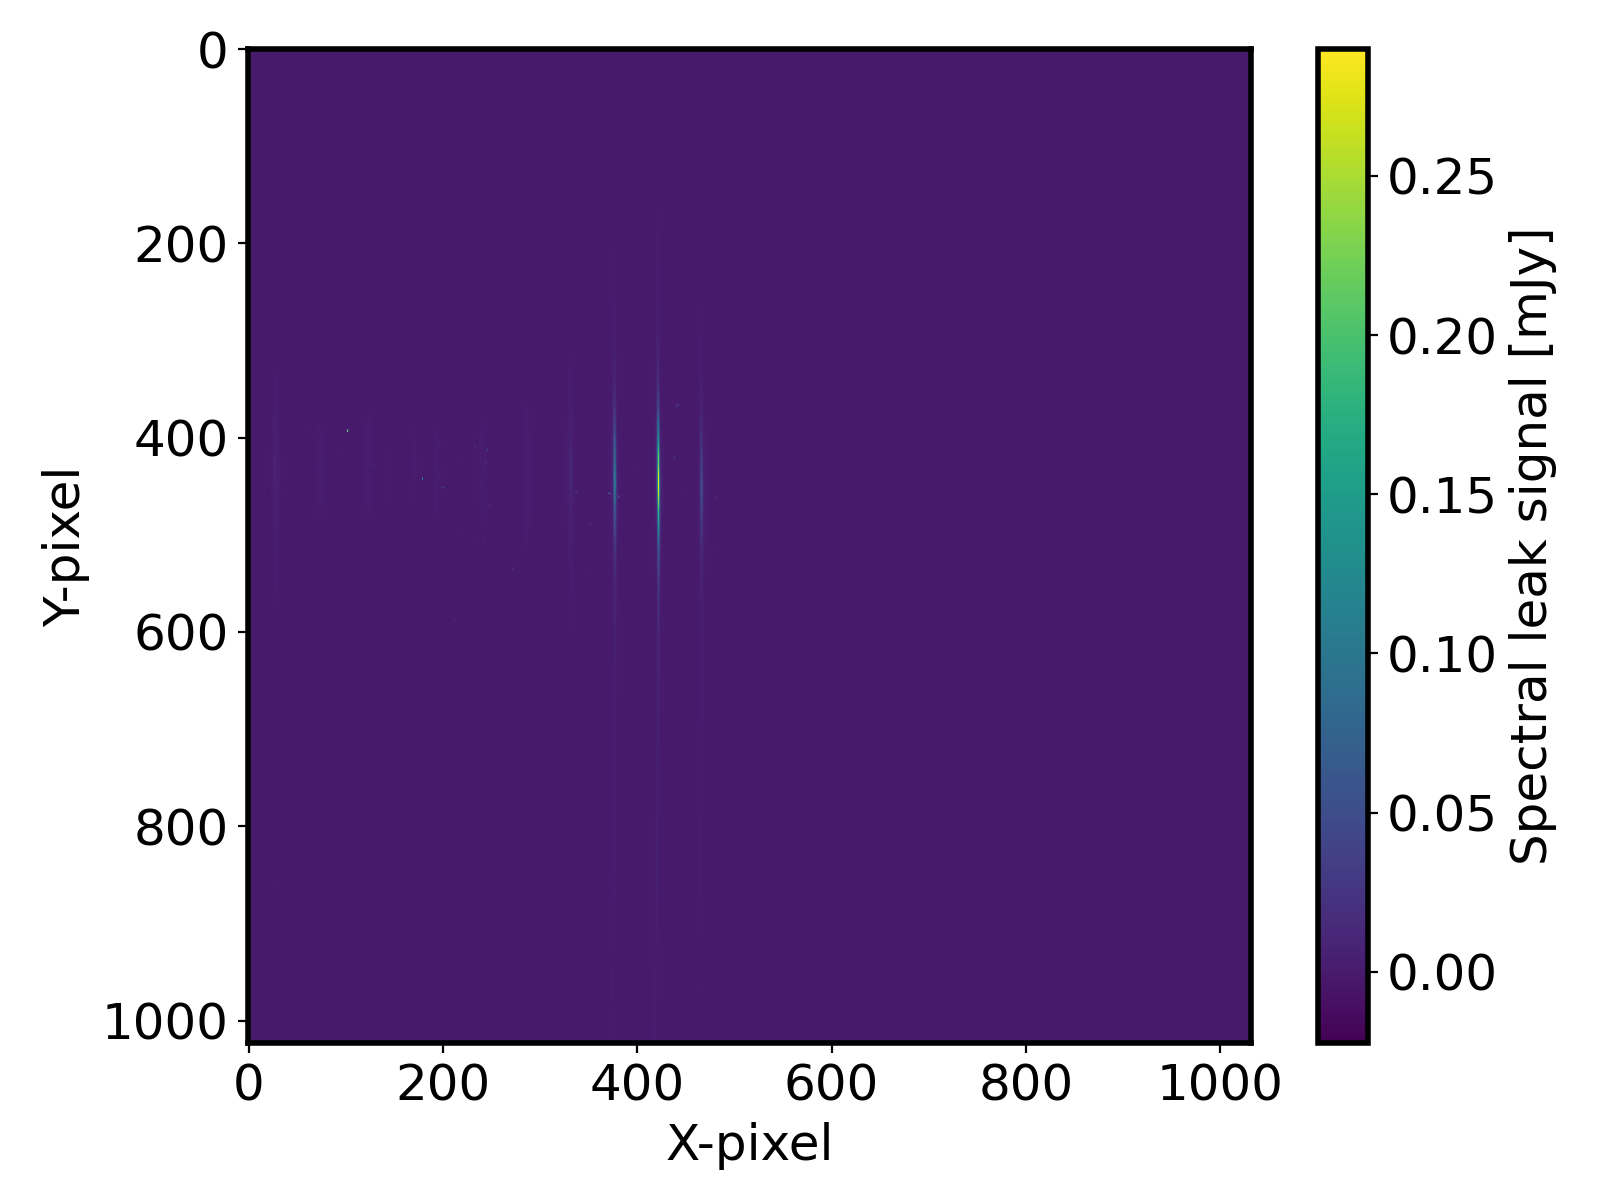

In [25]:
# Diffraction grating second order spectral leak contribution
if band == '1B':
    # Read the measured transmission curves from the csv files
    # zeroth colum is wavelength [micrometer]
    # first column is room temperature transmission
    # second column is 7K transmission
    col = 2
    filterWave= np.genfromtxt("MrsDichroicFilterTransmissions/fm_dichroics_1a.csv", delimiter=";")[:,0]
    D1A = np.genfromtxt("MrsDichroicFilterTransmissions/fm_dichroics_1a.csv", delimiter=";")[:,col]/100.
    D2A = np.genfromtxt("MrsDichroicFilterTransmissions/fm_dichroics_2a.csv", delimiter=";")[:,col]/100.
    D3A = np.genfromtxt("MrsDichroicFilterTransmissions/fm_dichroics_3a.csv", delimiter=";")[:,col]/100.

    # System transmission for MRS band 3A
    system_transmission_3A = D1A*D2A*(1-D3A)
    interp_sys_transm = interp1d(filterWave,system_transmission_3A)

    sys_transm_img = np.zeros((1024,1032))
    sel = np.nonzero(lambdaMap)
    sys_transm_img[sel] = interp_sys_transm(lambdaMap[sel])
    
    plt.close('all')
    plt.figure(figsize=(8,6))
    plt.imshow(sys_transm_img)
    clb = plt.colorbar()
    clb.set_label('Dichroic transmission [%]')
    plt.xlabel('X-pixel')
    plt.ylabel('Y-pixel')
    plt.tight_layout()
    
    # Compute spectral leak signal from band 1B and update the error map
    spectral_leak_sci_img = sci_img*sys_transm_img
    spectral_leak_err_img = err_img*sys_transm_img
    
    plt.figure(figsize=(8,6))
    plt.imshow(spectral_leak_sci_img*1000)
    clb = plt.colorbar()
    clb.set_label('Spectral leak signal [mJy]')
    plt.xlabel('X-pixel')
    plt.ylabel('Y-pixel')
    plt.tight_layout()
    
    # Redetermine optimal pixel weights for detector-based spectral extraction
    spectral_leak_weight_map = psf_img**2 / (spectral_leak_err_img)**2
    
    # Initialize placeholder
    spectral_leak_spectrum = np.zeros(nwavs)

In [26]:
# Perform detector-based spectral extraction
isolambda_spec_optimal[band] = np.zeros(nwavs)

for i in range(nwavs):
    #--determine pixels contributing to spectral bin
    test_img = np.zeros((1024,1032))
    idxs = np.argsort(np.abs(lambdas-wav_array[band][i]))[k]
    test_img[Y_flat[idxs],X_flat[idxs]] = 1
    
    # ascertain that only one pixel is selected per detector column
    outliers = np.where(np.sum(test_img,axis=0)==2)[0]

    for col in outliers:
        Y_ = np.argsort(np.abs(lambdaMap[:,col]-wav_array[band][i]))[1]
        test_img[Y_,col] = 0
    
    #--plot meant for debugging !!!ONLY USE AT A SINGLE WAVELENGTH!!!
    # plt.figure()
    # plt.imshow(test_img,aspect=0.5)
    # plt.tight_layout()

    #--spectral extraction
    sel_valid = (test_img==1) & nan_idx
    isolambda_spec_optimal[band][i] = np.sum(weight_map[sel_valid] * sci_img[sel_valid] / psf_img[sel_valid] ) / np.sum(weight_map[sel_valid])
    
    if band == '1B':
        # Estimate diffraction grating second order spectral leak contribution
        spectral_leak_spectrum[i] = np.sum(spectral_leak_weight_map[sel_valid] * spectral_leak_sci_img[sel_valid] / psf_img[sel_valid] ) / np.sum(spectral_leak_weight_map[sel_valid])

<IPython.core.display.Javascript object>


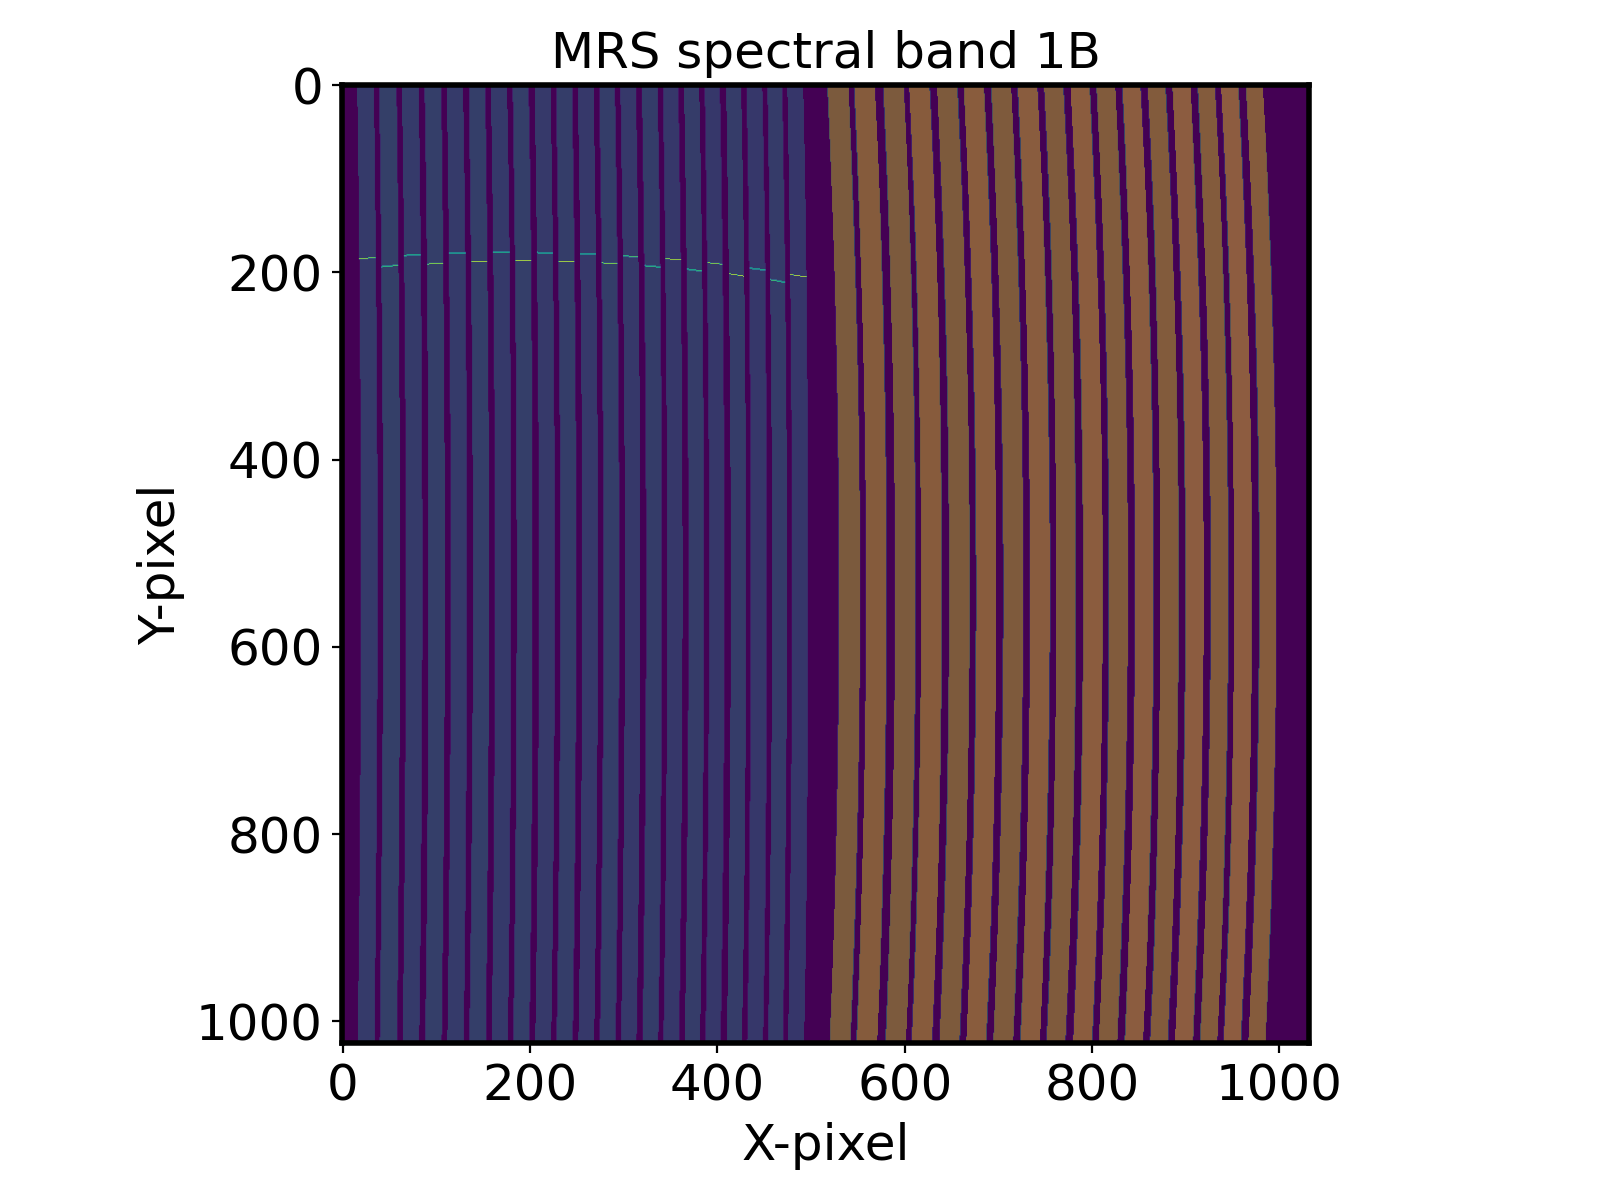

In [27]:
# debugging spectral bins

i = 200
#--determine pixels contributing to spectral bin
test_img = np.zeros((1024,1032))
idxs = np.argsort(np.abs(lambdas-wav_array[band][i]))[k]
test_img[Y_flat[idxs],X_flat[idxs]] = 1

# ascertain that only one pixel is selected per detector column
outliers = np.where(np.sum(test_img,axis=0)==2)[0]

for col in outliers:
    Y_ = np.argsort(np.abs(lambdaMap[:,col]-wav_array[band][i]))[1]
    test_img[Y_,col] = 0

plt.figure(figsize=(8,6))
plt.imshow(test_img)
plt.imshow(d2cMaps['sliceMap'],alpha=0.4)
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.title('MRS spectral band {}'.format(band))
plt.tight_layout()

<IPython.core.display.Javascript object>


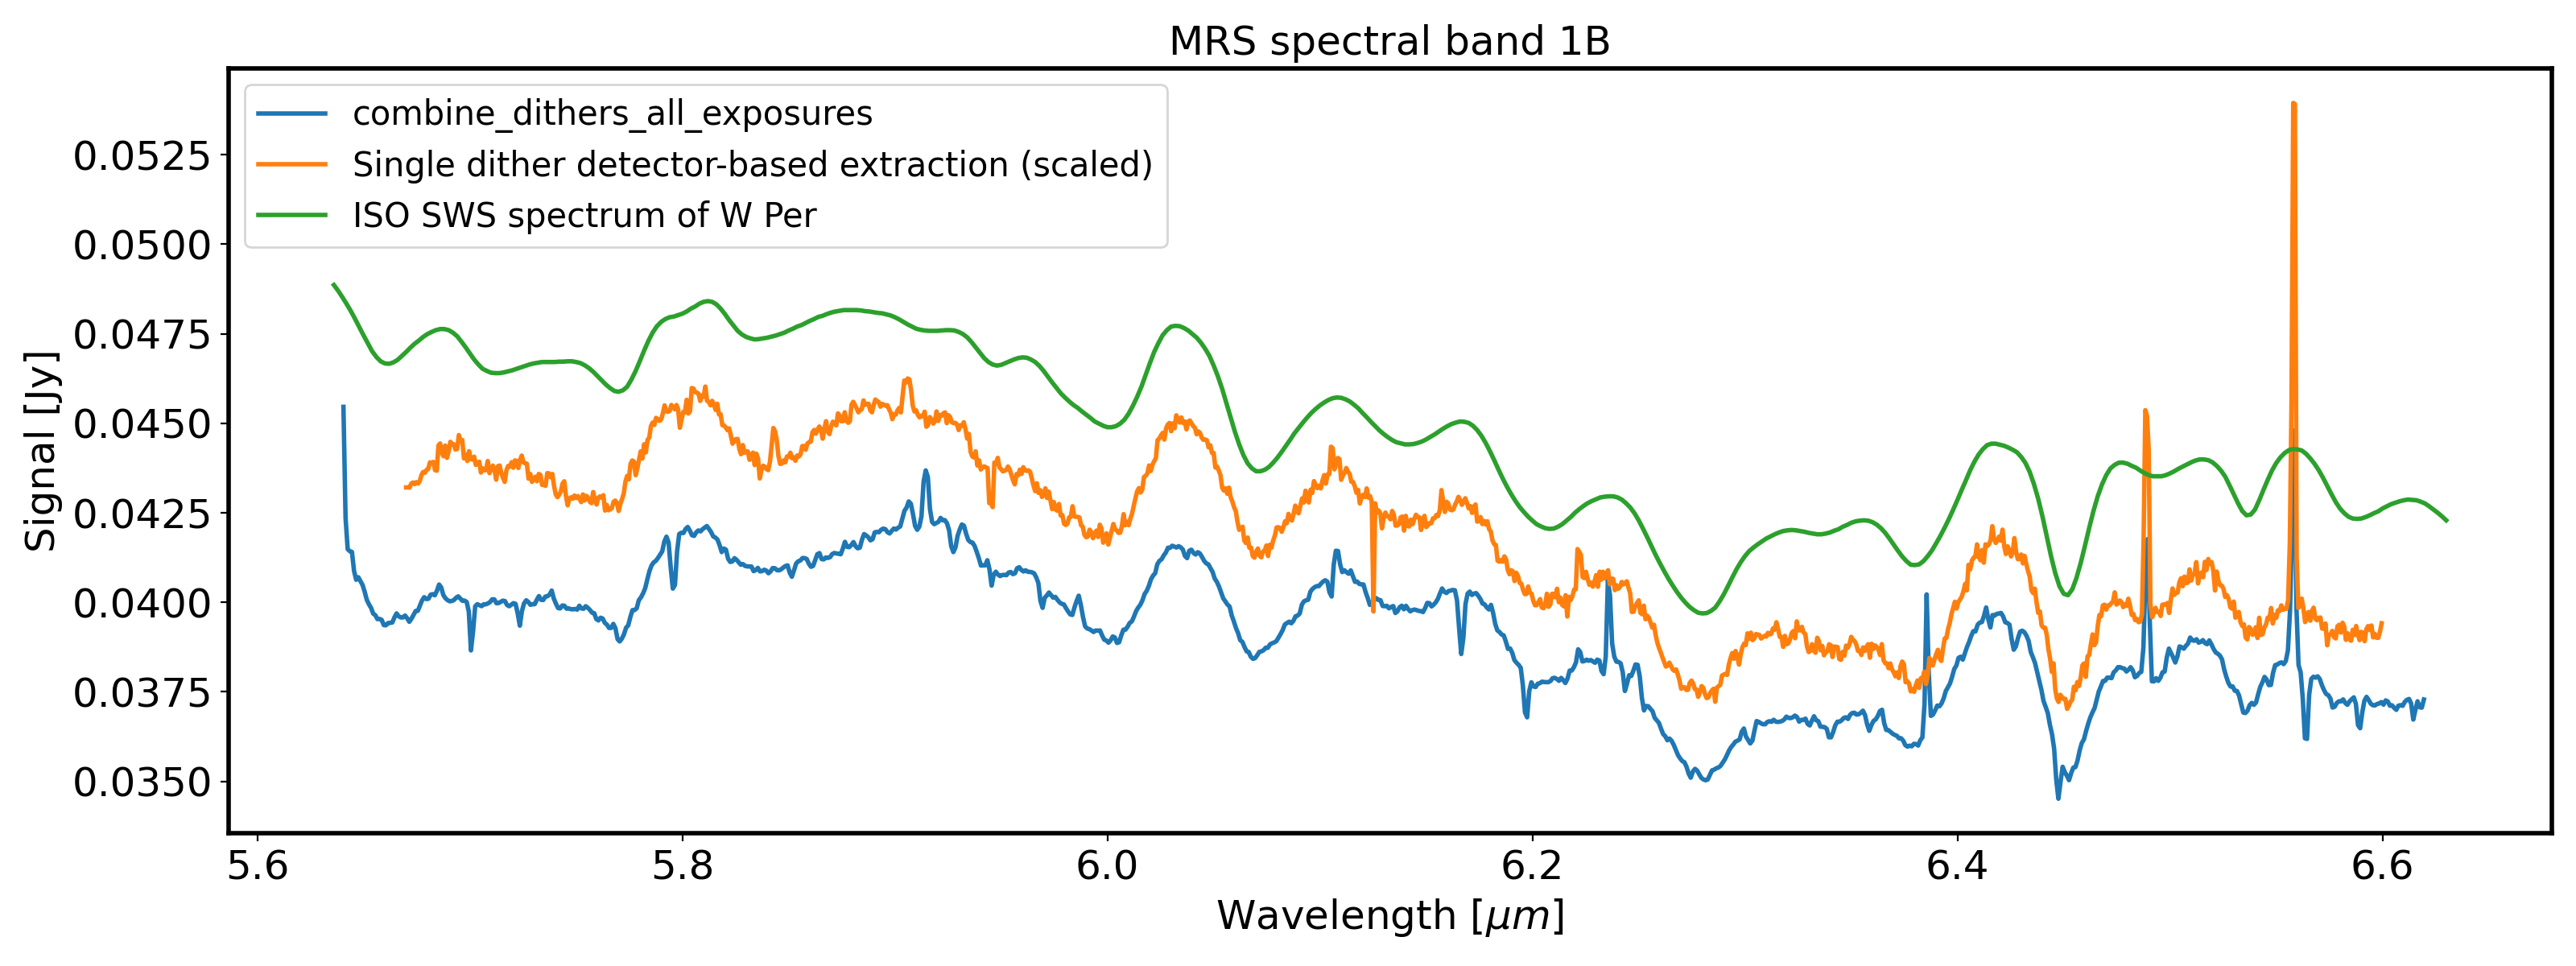

<IPython.core.display.Javascript object>


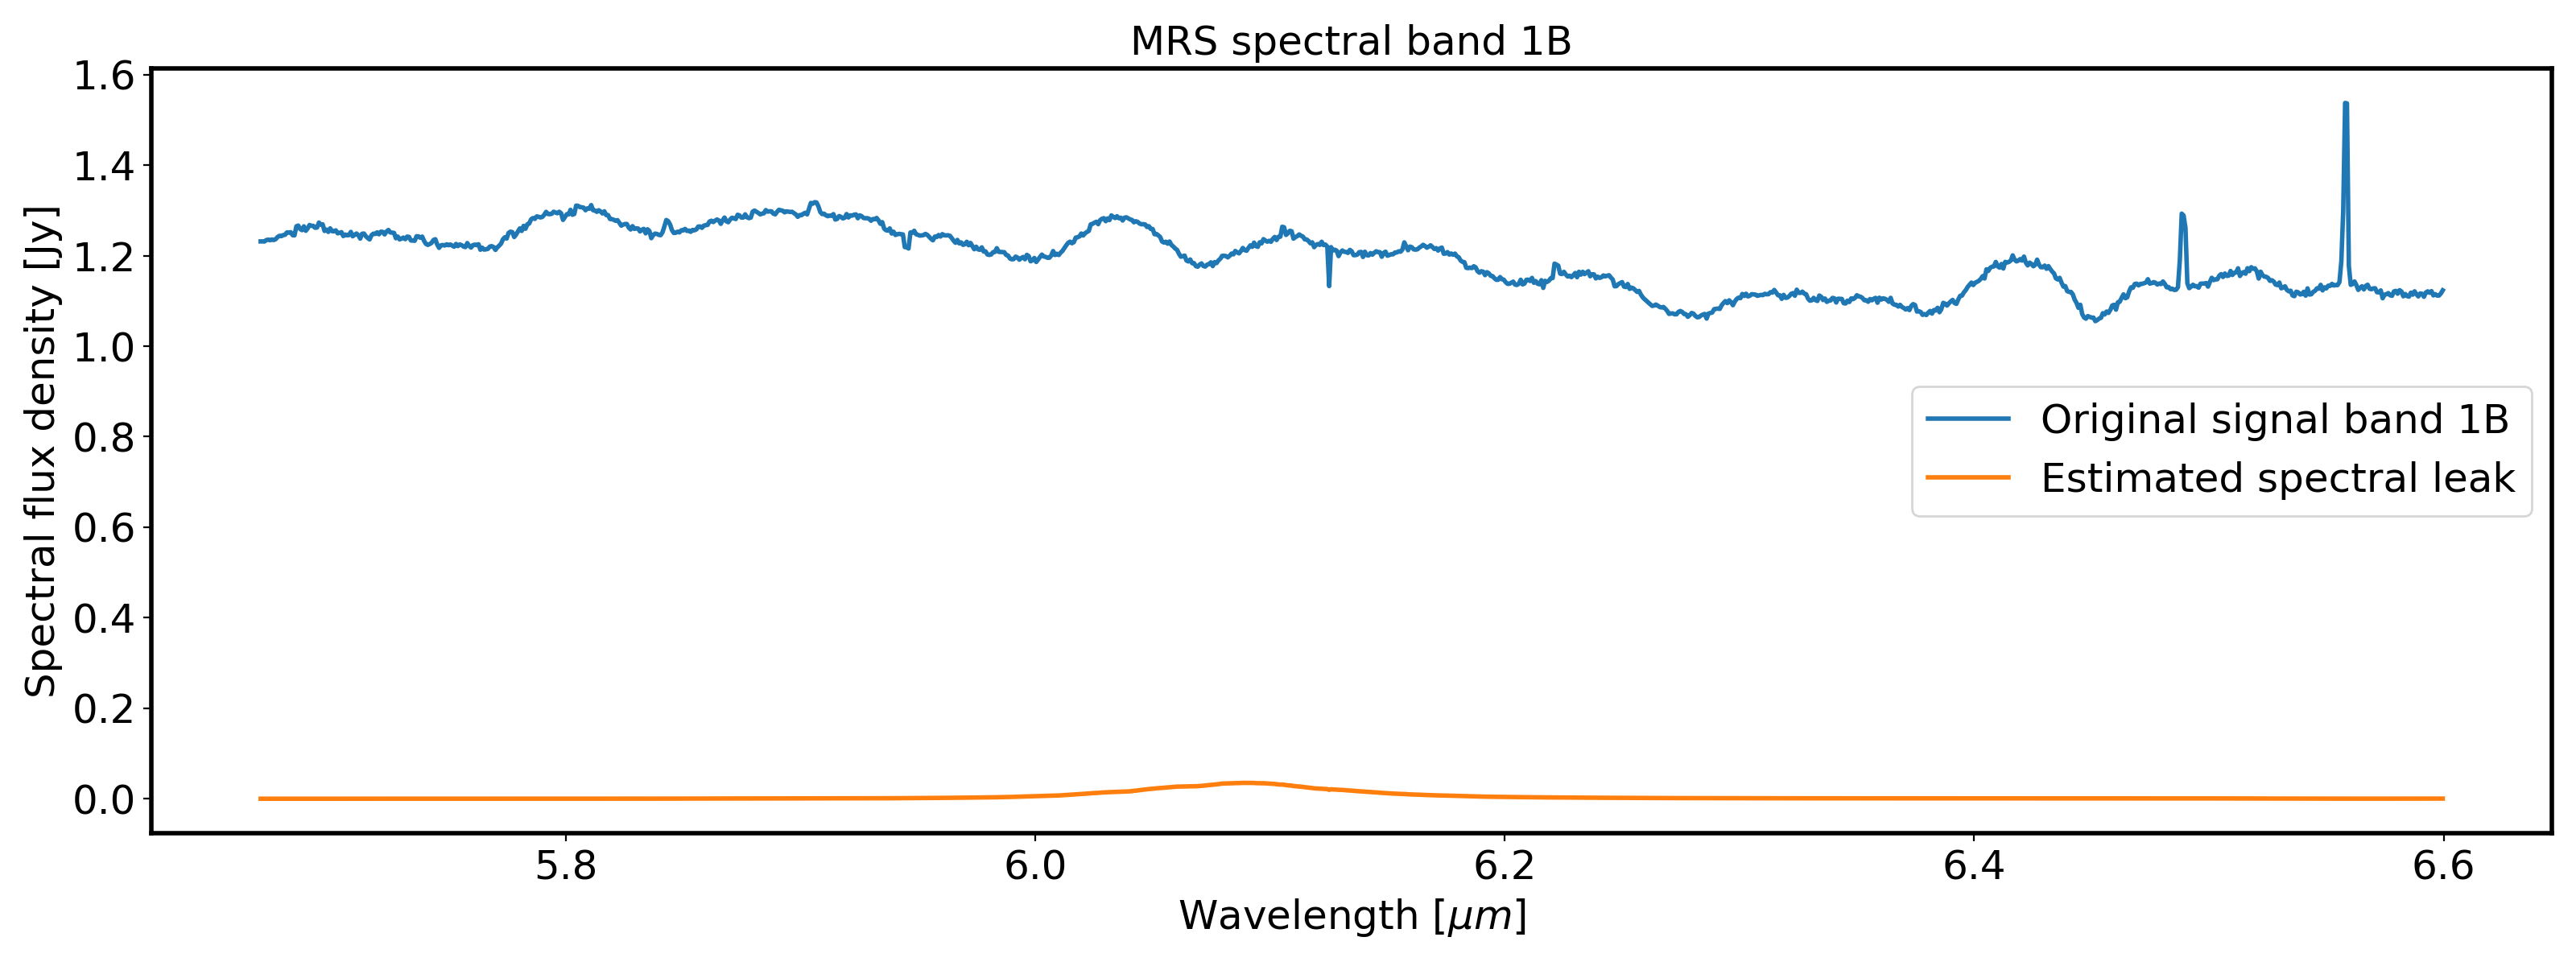

In [28]:
# Compare resulting extracted spectrum to result from JWST-pipeline-reconstructed spectrum and original ISO spectrum
# Disclaimer: Due to flux conservation issues in MIRISim, the  MIRISim MRS PSF is broader than the MRS PSF CDP model. 
# This results on the detector-based spectrum having a significantly higher spectral baseline.

#--JWST pipeline result
hdu = fits.open('combine_dithers_all_exposures_ch{}-{}_x1d.fits'.format(ch,band_id))
wav = hdu[1].data['WAVELENGTH']
flux = hdu[1].data['FLUX']
hdu.close()

#--Original ISO spectrum
W_Per_hdu = fits.open('W_Per_spectrum_sws.fit')
wav_WPer = W_Per_hdu[0].data[:,0]
flux_WPer = W_Per_hdu[0].data[:,1]
sel_WPer = (wav_WPer>lambmin) & (wav_WPer<lambmax)
W_Per_hdu.close()

#--Plot
if band in ['1A','1B','1C']:
    fudge_factor = 28.5
elif band in ['2A','2B','2C']:
    fudge_factor = 45
plt.close('all')
plt.figure(figsize=(16,6))
plt.plot(wav,flux,label='combine_dithers_all_exposures')
plt.plot(wav_array[band],isolambda_spec_optimal[band]/fudge_factor,label='Single dither detector-based extraction (scaled)')
plt.plot(wav_WPer[sel_WPer],flux_WPer[sel_WPer]/1000.,label='ISO SWS spectrum of W Per')
plt.xlabel(r'Wavelength [$\mu m$]')
plt.ylabel(r'Signal [Jy]')
plt.title('MRS spectral band {}'.format(band))
plt.legend(fontsize=15)
plt.tight_layout()

if band == '1B':
    plt.figure(figsize=(16,6))
    plt.plot(wav_array[band],isolambda_spec_optimal[band],label='Original signal band 1B')
    plt.plot(wav_array[band],spectral_leak_spectrum,label='Estimated spectral leak')
    plt.xlabel('Wavelength [$\mu m$]')
    plt.ylabel('Spectral flux density [Jy]')
    plt.title('MRS spectral band 1B')
    plt.legend()
    plt.tight_layout()

## Correct for spectral leak if MRS band is set to 3A
## CAUTION: In order for the following cell to work, the user must have run this notebook already once for band 1B.

In [29]:
if band == '3A':
    spectral_leak_corr_band3A = isolambda_spec_optimal[band]-spectral_leak_spectrum

# THE END

## Still to do:
- Loop the notebook over all dither positions and average the resulting spectra. The reason why we may not want to use all four dithers in one go (i.e. to run the detector based extraction only once) is because we will likely find variations in the PSF as a function of which slice gets illuminated on the detector (think incoming cone angle and detector-scattered light).

## About this notebook
**Author:** Ioannis (Yannis) Argyriou, Post-Doctoral Researcher, Institute of Astronomy, KU Leuven, Belgium  
**Date:** 2022-01-08

***

[Top of Page](#top)